<a href="https://colab.research.google.com/github/markotesic/melting-pot-competition-data/blob/main/Melting_pot_competition_data_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install 'pymc>5.9' --quiet
! pip install 'numpyro' --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.9/370.9 kB 25.6 MB/s eta 0:00:00


In [2]:
!pip install tabpfn --quiet
!git clone https://github.com/PriorLabs/tabpfn-extensions
!pip install -e tabpfn-extensions --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.7/173.7 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 kB 9.9 MB/s eta 0:00:00
Cloning into 'tabpfn-extensions'...
remote: Enumerating objects: 3199, done.
remote: Counting objects: 100% (939/939), done.
remote: Compressing objects: 100% (299/299), done.
remote: Total 3199 (delta 805), reused 641 (delta 640), pack-reused 2260 (from 2)
Receiving objects: 100% (3199/3199), 1.23 MiB | 23.82 MiB/s, done.
Resolving deltas: 100% (1971/1971), done.
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tabpfn-extensions (pyproject.toml) ... done


In [3]:
import warnings

# Filter warnings for the specific library you want to suppress
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

import arviz as az
import numpy as np
import pandas as pd
import pickle
import pymc as pm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, brier_score_loss, average_precision_score, f1_score, mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
#from tabpfn import TabPFNClassifier, TabPFNRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
plt.rcParams['figure.constrained_layout.use'] = True

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on xgboost v{xgb.__version__}")

Running on PyMC v5.25.1
Running on xgboost v3.0.5


In [4]:
!python --version

Python 3.12.11


In [59]:
all_data = pd.read_csv('https://raw.githubusercontent.com/markotesic/melting-pot-competition-data/refs/heads/main/Data/data_top_12_teams.csv?token=GHSAT0AAAAAADI3RP23CFCATAJUFZZLWXDM2GLDJ3Q')

In [60]:
all_data.head()

Submission ID Team Name    Substrate Name        Scenario Name  Episode No  \
0   team_1_id_1    team_1  territory__rooms  territory__rooms_12           0   
1   team_1_id_1    team_1  territory__rooms  territory__rooms_12           1   
2   team_1_id_1    team_1  territory__rooms  territory__rooms_12           2   
3   team_1_id_1    team_1  territory__rooms  territory__rooms_12           3   
4   team_1_id_1    team_1  territory__rooms  territory__rooms_12           4   

   Normalized Score   Score prosocial_newcomers reciprocity acceptance  ...  \
0          9.885881  3515.0                   N           N          N  ...   
1          1.705465   719.5                   N           N          N  ...   
2          1.739117   731.0                   N           N          N  ...   
3          2.596518  1024.0                   N           N          N  ...   
4          2.382899   951.0                   N           N          N  ...   

  convention_following teaching sanctioning enforcement partner_choice  \
0                    N        N           N           N              N   
1                    N        N           N           N              N   
2                    N        N           N           N              N   
3                    N        N           N           N              N   
4                    N        N           N           N              N   

  time_pressure chance_to_benefit_oneself_without_imposing_social_cost  \
0             N                                                  N       
1             N                                                  N       
2             N                                                  N       
3             N                                                  N       
4             N                                                  N       

  defense ostracism forgiveness  
0       Y         N           N  
1       Y         N           N  
2       Y         N           N  
3       Y         N           N  
4       Y         N           N  

[5 rows x 23 columns]

In [61]:
# Identify binary columns (assuming 'Y' and 'N' as values)
binary_cols = [col for col in all_data.columns if all_data[col].dropna().isin(['Y', 'N']).all()]

In [62]:
scenario_df = all_data.groupby("Scenario Name")[binary_cols].apply(
    lambda group: group.apply(
        lambda col: 'Y' if (col == 'Y').all()
        else 'N' if (col == 'N').all()
        else 'B'
    )
).reset_index()
scenario_df.head()

Scenario Name prosocial_newcomers reciprocity acceptance  \
0  allelopathic_harvest__open_10                   N           N          N   
1  allelopathic_harvest__open_11                   N           N          N   
2  allelopathic_harvest__open_12                   N           N          N   
3   allelopathic_harvest__open_3                   N           N          N   
4   allelopathic_harvest__open_4                   N           N          N   

  flexibility resident visitor convention_following teaching sanctioning  \
0           N        N       N                    Y        N           N   
1           N        N       N                    Y        N           N   
2           N        N       N                    Y        N           N   
3           N        N       N                    Y        N           N   
4           N        N       N                    Y        N           N   

  enforcement partner_choice time_pressure  \
0           N              N             N   
1           N              N             N   
2           N              N             N   
3           N              N             N   
4           N              N             N   

  chance_to_benefit_oneself_without_imposing_social_cost defense ostracism  \
0                                                  N           N         N   
1                                                  N           N         N   
2                                                  N           N         N   
3                                                  N           N         N   
4                                                  N           N         N   

  forgiveness  
0           N  
1           N  
2           N  
3           N  
4           N

/tmp/ipython-input-4154883380.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


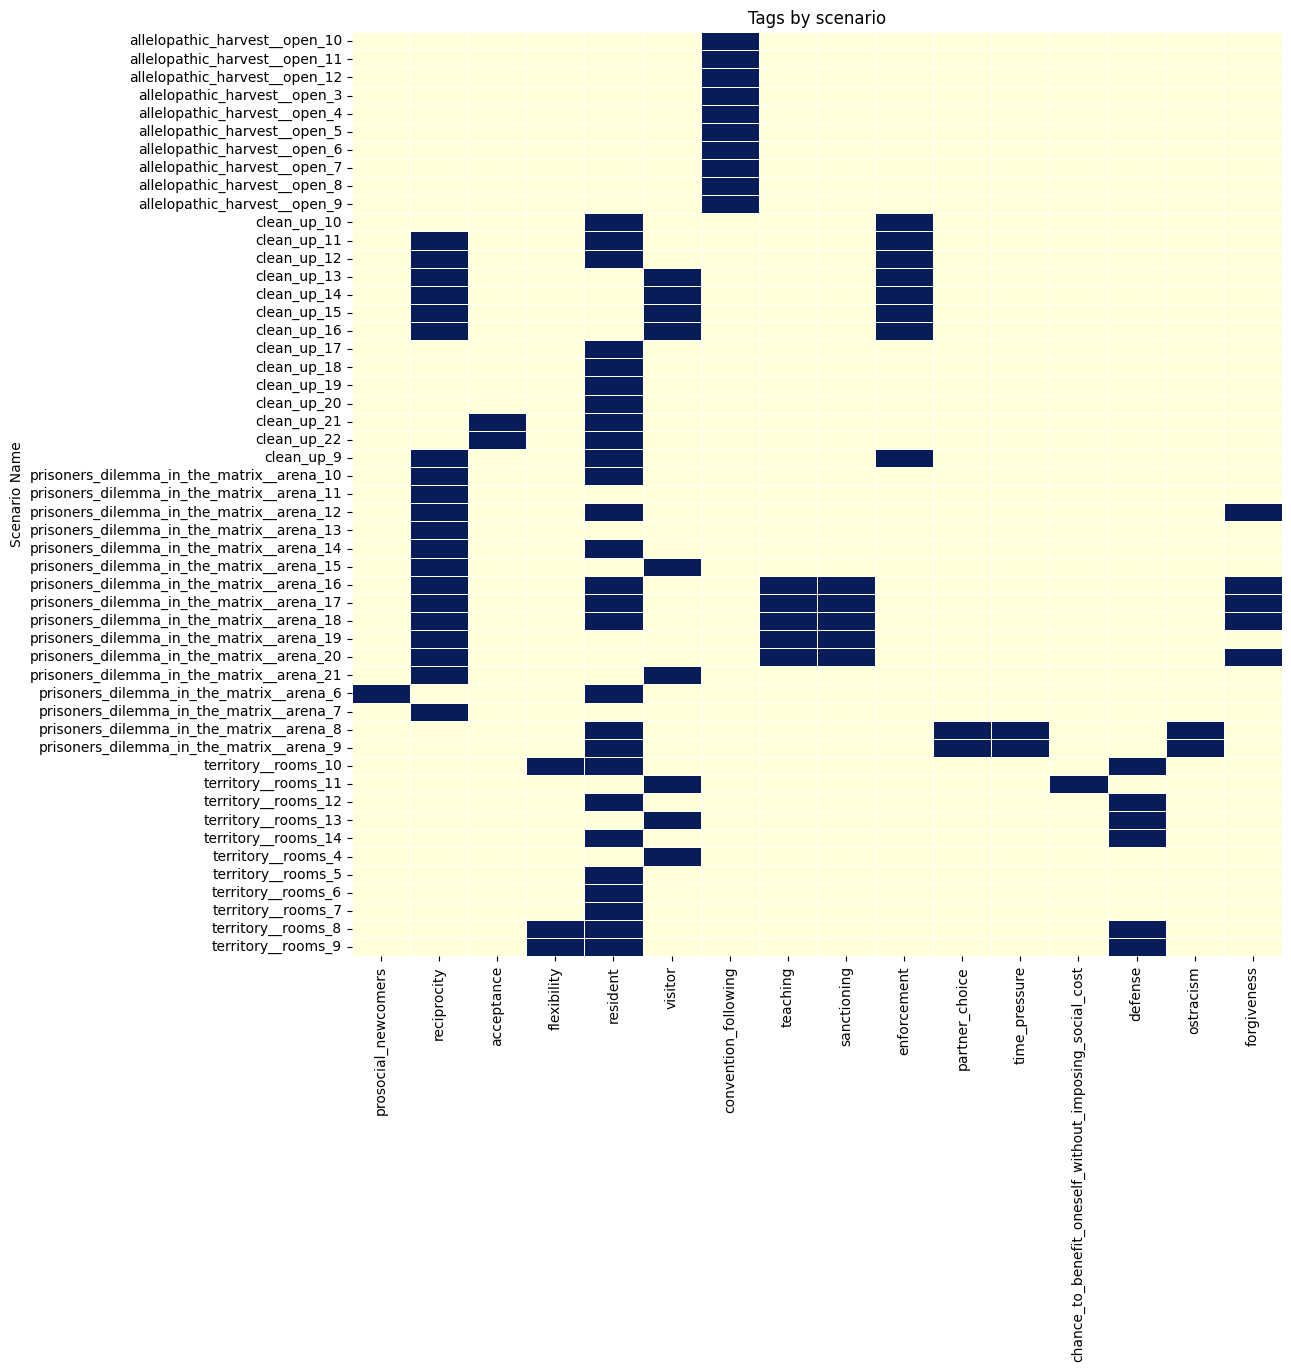

In [63]:
binary_matrix = scenario_df.set_index("Scenario Name").map(lambda x: x == 'Y').astype(int)

save = False
# Plot the heatmap with a simplified layout
plt.figure(figsize=(12, 12))
plt.tight_layout()
sns.heatmap(binary_matrix, annot=False, cmap="YlGnBu", cbar=False, linewidths=0.5)
plt.xticks(ticks=[i + 0.5 for i in range(binary_matrix.shape[1])], labels=binary_matrix.columns, rotation=90)
plt.yticks(ticks=[i + 0.5 for i in range(binary_matrix.shape[0])], labels=binary_matrix.index)
plt.title("Tags by scenario")
if save:
  filename = "/content/drive/MyDrive/Colab Notebooks/Melting pot/Competition data/tags_by_scenario.png"
  plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

### Noramlised score by episodes

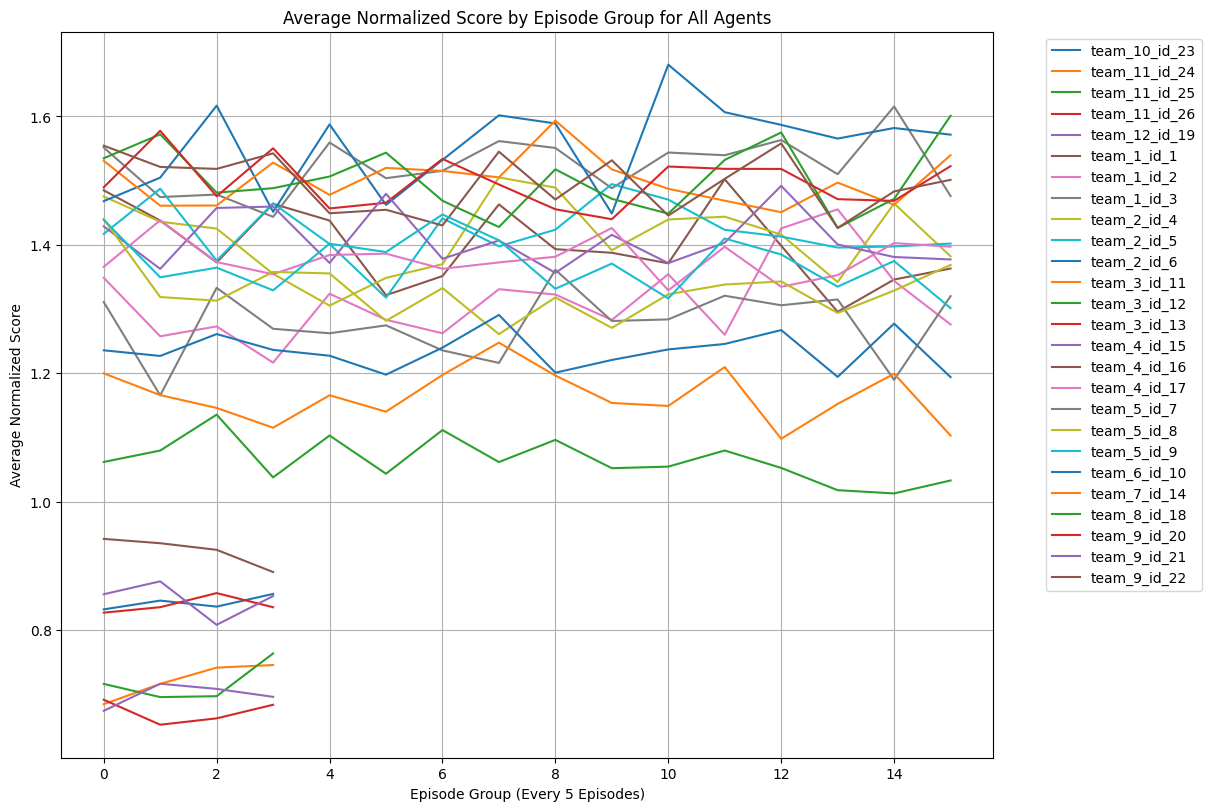

In [64]:
# Group by 'Submission ID' and 'Episode No', then calculate mean and standard deviation
agent_episode_stats = all_data.groupby(['Submission ID', 'Episode No'])['Normalized Score'].agg(['mean', 'std'])
agent_episode_stats = agent_episode_stats.rename(columns={'mean': 'Mean Normalized Score', 'std': 'SD Normalized Score'})
agent_episode_stats = agent_episode_stats.reset_index()

n_episodes = 5
agent_episode_stats['Episode Group'] = (agent_episode_stats['Episode No']) // n_episodes  # Calculate episode groups
averaged_stats = agent_episode_stats.groupby(['Submission ID', 'Episode Group'])[['Mean Normalized Score', 'SD Normalized Score']].mean().reset_index()

save = False
# Create a single plot with all agents
plt.figure(figsize=(12, 8))

for agent in averaged_stats['Submission ID'].unique():
    agent_data = averaged_stats[averaged_stats['Submission ID'] == agent]
    plt.plot(agent_data['Episode Group'], agent_data['Mean Normalized Score'], label=agent)

plt.xlabel(f'Episode Group (Every {n_episodes} Episodes)')
plt.ylabel('Average Normalized Score')
plt.title('Average Normalized Score by Episode Group for All Agents')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
if save:
  filename = "/content/drive/MyDrive/Colab Notebooks/Melting pot/Competition data/scores_over_episodes.png"
  plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

In [65]:
from statsmodels.regression.mixed_linear_model import MixedLM

md = MixedLM.from_formula(
    'Q("Normalized Score") ~ Q("Episode No")',
    groups='Submission ID',
    data=all_data
)
mdu = md.fit()
print(mdu.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Q("Normalized Score")
No. Observations: 81600   Method:             REML                 
No. Groups:       26      Scale:              1.3151               
Min. group size:  1020    Log-Likelihood:     -127038.6097         
Max. group size:  4080    Converged:          Yes                  
Mean group size:  3138.5                                           
--------------------------------------------------------------------
                     Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept             1.199     0.066  18.191  0.000   1.070   1.328
Q("Episode No")      -0.000     0.000  -0.203  0.839  -0.000   0.000
Submission ID Var     0.112     0.034                               



### Aggregated data

In [67]:
all_data['Episode Group'] = (all_data['Episode No']) // 5

aggregated_data = all_data.groupby(['Submission ID', 'Scenario Name','Episode Group']).agg({
    'Normalized Score': 'mean',
    'Score': 'mean',
    'Team Name': 'first',
    'Substrate Name': 'first',
    'prosocial_newcomers': 'first',
    'reciprocity': 'first',
    'acceptance': 'first',
    'flexibility': 'first',
    'resident': 'first',
    'visitor': 'first',
    'convention_following': 'first',
    'teaching': 'first',
    'sanctioning': 'first',
    'enforcement': 'first',
    'partner_choice': 'first',
    'time_pressure': 'first',
    'chance_to_benefit_oneself_without_imposing_social_cost': 'first',
    'defense': 'first',
    'ostracism': 'first',
    'forgiveness': 'first'
}).reset_index()

In [68]:
aggregated_data.shape

(16320, 23)

In [69]:
aggregated_data.describe()

Episode Group  Normalized Score         Score
count   16320.000000      16320.000000  16320.000000
mean        6.900000          1.320833    293.140432
std         4.742508          0.979274    281.571182
min         0.000000         -0.237364      0.400000
25%         3.000000          0.750601     45.607062
50%         7.000000          1.005314    227.814286
75%        11.000000          1.512263    454.750000
max        15.000000          8.548885   2226.000000

In [70]:
aggregated_data.describe(include=object)

Submission ID                  Scenario Name Team Name  \
count          16320                          16320     16320   
unique            26                             51        12   
top      team_2_id_4  allelopathic_harvest__open_10    team_1   
freq             816                            320      2448   

                                Substrate Name prosocial_newcomers  \
count                                    16320               16320   
unique                                       4                   2   
top     prisoners_dilemma_in_the_matrix__arena                   N   
freq                                      5120               16000   

       reciprocity acceptance flexibility resident visitor  \
count        16320      16320       16320    16320   16320   
unique           2          2           2        2       2   
top              N          N           N        Y       N   
freq          9920      15680       15360     8640   13440   

       convention_following teaching sanctioning enforcement partner_choice  \
count                 16320    16320       16320       16320          16320   
unique                    2        2           2           2              2   
top                       N        N           N           N              N   
freq                  13120    14720       14720       13760          15680   

       time_pressure chance_to_benefit_oneself_without_imposing_social_cost  \
count          16320                                              16320       
unique             2                                                  2       
top                N                                                  N       
freq           15680                                              16000       

       defense ostracism forgiveness  
count    16320     16320       16320  
unique       2         2           2  
top          N         N           N  
freq     14400     15680       14720

## Score transformations

In [71]:
scaler = MinMaxScaler()

In [72]:
aggregated_data['MinMax Normalized Score AA'] = scaler.fit_transform(aggregated_data[['Normalized Score']])
aggregated_data.describe()

Episode Group  Normalized Score         Score  \
count   16320.000000      16320.000000  16320.000000   
mean        6.900000          1.320833    293.140432   
std         4.742508          0.979274    281.571182   
min         0.000000         -0.237364      0.400000   
25%         3.000000          0.750601     45.607062   
50%         7.000000          1.005314    227.814286   
75%        11.000000          1.512263    454.750000   
max        15.000000          8.548885   2226.000000   

       MinMax Normalized Score AA  
count                16320.000000  
mean                     0.177345  
std                      0.111455  
min                      0.000000  
25%                      0.112444  
50%                      0.141434  
75%                      0.199132  
max                      1.000000

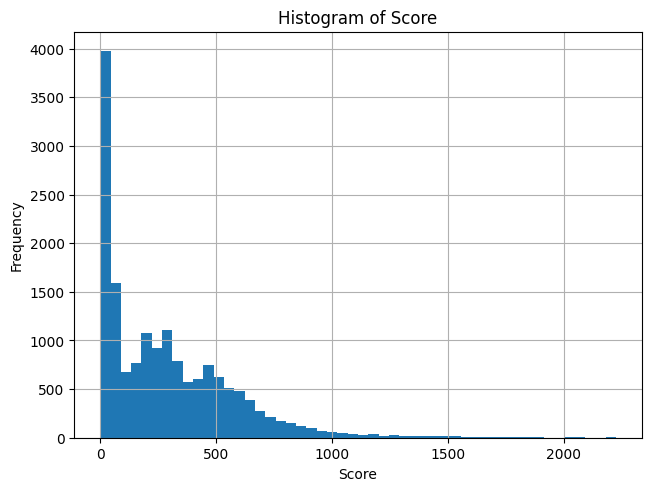

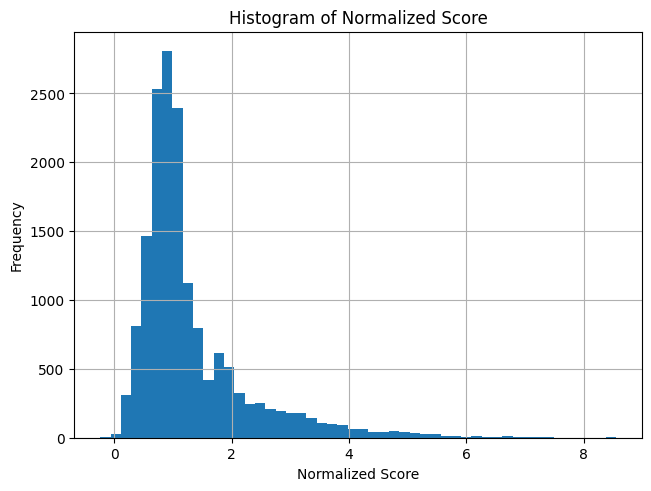

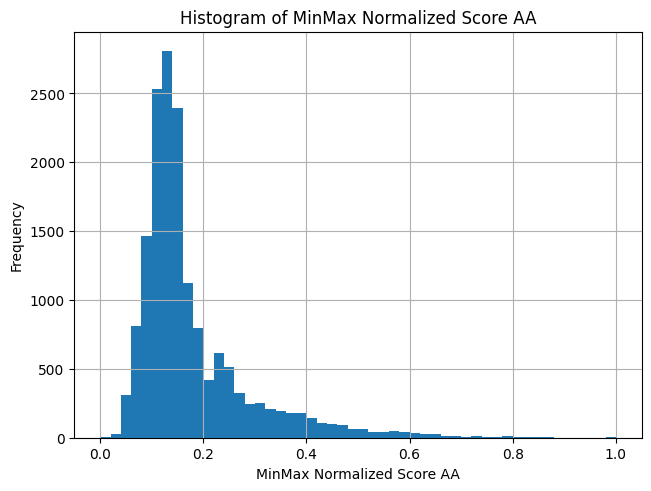

In [73]:
scores = ['Score','Normalized Score','MinMax Normalized Score AA']

for score in scores:
  aggregated_data[score].hist(bins=50)
  plt.title(f'Histogram of {score}')
  plt.xlabel(score)
  plt.ylabel('Frequency')
  plt.show()

/tmp/ipython-input-1550509006.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Submission ID', y=score, data=aggregated_data,order=mean_score.index, capsize=.2, errorbar='ci', palette='viridis')


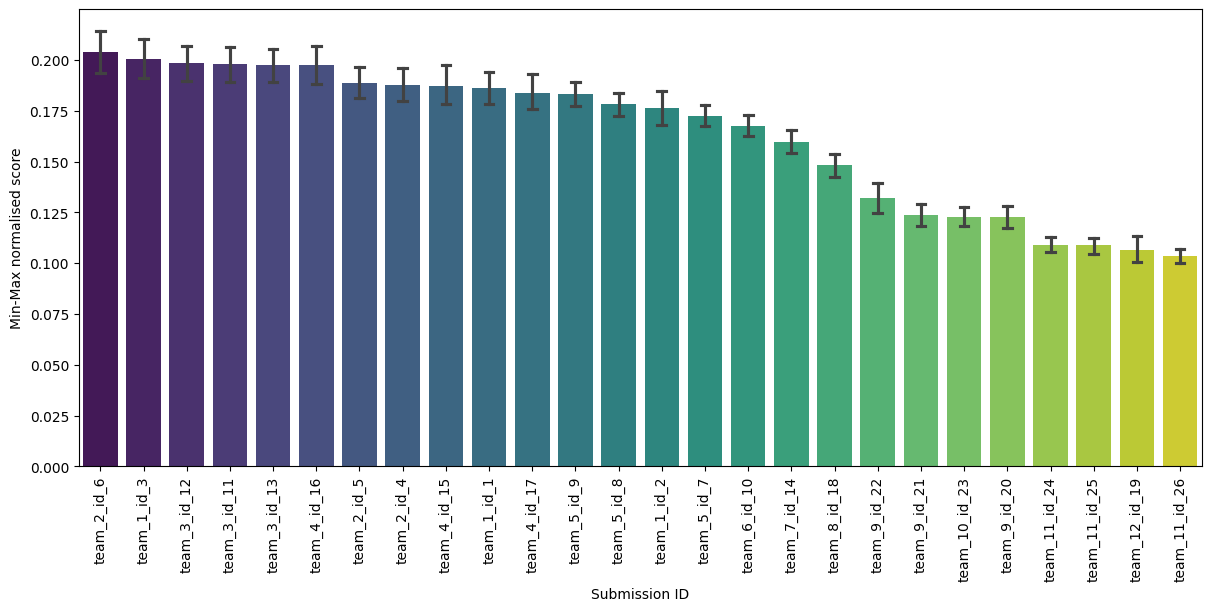

In [74]:
score = 'MinMax Normalized Score AA'
mean_score = aggregated_data.groupby('Submission ID')[score].mean().sort_values(ascending=False)
save = False
# Create a bar plot with error bars that show the standard deviation
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Submission ID', y=score, data=aggregated_data,order=mean_score.index, capsize=.2, errorbar='ci', palette='viridis')

# Setting titles and labels
#plt.title(f'Mean and confidence intervals of {score} by Submission ID')
plt.xlabel('Submission ID')
plt.ylabel('Min-Max normalised score')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
if save:
  filename = "/content/drive/MyDrive/Colab Notebooks/Melting pot/Competition data/average_scores.png"
  plt.savefig(filename, dpi=300, bbox_inches='tight')
# Show plot
plt.show()

## Data for analysis

In [75]:
all_agents = aggregated_data['Submission ID'].unique()
all_agents

array(['team_10_id_23', 'team_11_id_24', 'team_11_id_25', 'team_11_id_26',
       'team_12_id_19', 'team_1_id_1', 'team_1_id_2', 'team_1_id_3',
       'team_2_id_4', 'team_2_id_5', 'team_2_id_6', 'team_3_id_11',
       'team_3_id_12', 'team_3_id_13', 'team_4_id_15', 'team_4_id_16',
       'team_4_id_17', 'team_5_id_7', 'team_5_id_8', 'team_5_id_9',
       'team_6_id_10', 'team_7_id_14', 'team_8_id_18', 'team_9_id_20',
       'team_9_id_21', 'team_9_id_22'], dtype=object)

In [79]:
competition_data_df = aggregated_data[aggregated_data['Submission ID'].isin(all_agents)]
competition_data_df = competition_data_df.drop(['Team Name','Scenario Name','Episode Group',], axis=1)
boolean_columns = [col for col in competition_data_df.columns if competition_data_df[col].dropna().isin(['Y', 'N']).all()]
replacement_dict = {'Y': 1, 'N': 0}
competition_data_df[boolean_columns] = competition_data_df[boolean_columns].replace(replacement_dict).astype(int)
competition_data_df.head()

/tmp/ipython-input-3434253664.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  competition_data_df[boolean_columns] = competition_data_df[boolean_columns].replace(replacement_dict).astype(int)


Submission ID  Normalized Score       Score              Substrate Name  \
0  team_10_id_23          0.796177  284.133333  allelopathic_harvest__open   
1  team_10_id_23          0.793970  283.466667  allelopathic_harvest__open   
2  team_10_id_23          0.780286  279.333333  allelopathic_harvest__open   
3  team_10_id_23          0.795295  283.866667  allelopathic_harvest__open   
4  team_10_id_23          0.954777  106.385714  allelopathic_harvest__open   

   prosocial_newcomers  reciprocity  acceptance  flexibility  resident  \
0                    0            0           0            0         0   
1                    0            0           0            0         0   
2                    0            0           0            0         0   
3                    0            0           0            0         0   
4                    0            0           0            0         0   

   visitor  ...  teaching  sanctioning  enforcement  partner_choice  \
0        0  ...         0            0            0               0   
1        0  ...         0            0            0               0   
2        0  ...         0            0            0               0   
3        0  ...         0            0            0               0   
4        0  ...         0            0            0               0   

   time_pressure  chance_to_benefit_oneself_without_imposing_social_cost  \
0              0                                                  0        
1              0                                                  0        
2              0                                                  0        
3              0                                                  0        
4              0                                                  0        

   defense  ostracism  forgiveness  MinMax Normalized Score AA  
0        0          0            0                    0.117632  
1        0          0            0                    0.117381  
2        0          0            0                    0.115823  
3        0          0            0                    0.117531  
4        0          0            0                    0.135683  

[5 rows x 21 columns]

In [78]:
competition_data_df.describe()

Normalized Score         Score  prosocial_newcomers   reciprocity  \
count      16320.000000  16320.000000         16320.000000  16320.000000   
mean           1.320833    293.140432             0.019608      0.392157   
std            0.979274    281.571182             0.138653      0.488246   
min           -0.237364      0.400000             0.000000      0.000000   
25%            0.750601     45.607062             0.000000      0.000000   
50%            1.005314    227.814286             0.000000      0.000000   
75%            1.512263    454.750000             0.000000      1.000000   
max            8.548885   2226.000000             1.000000      1.000000   

         acceptance   flexibility      resident       visitor  \
count  16320.000000  16320.000000  16320.000000  16320.000000   
mean       0.039216      0.058824      0.529412      0.176471   
std        0.194114      0.235301      0.499149      0.381232   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      1.000000      0.000000   
75%        0.000000      0.000000      1.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000   

       convention_following      teaching   sanctioning   enforcement  \
count          16320.000000  16320.000000  16320.000000  16320.000000   
mean               0.196078      0.098039      0.098039      0.156863   
std                0.397041      0.297377      0.297377      0.363682   
min                0.000000      0.000000      0.000000      0.000000   
25%                0.000000      0.000000      0.000000      0.000000   
50%                0.000000      0.000000      0.000000      0.000000   
75%                0.000000      0.000000      0.000000      0.000000   
max                1.000000      1.000000      1.000000      1.000000   

       partner_choice  time_pressure  \
count    16320.000000   16320.000000   
mean         0.039216       0.039216   
std          0.194114       0.194114   
min          0.000000       0.000000   
25%          0.000000       0.000000   
50%          0.000000       0.000000   
75%          0.000000       0.000000   
max          1.000000       1.000000   

       chance_to_benefit_oneself_without_imposing_social_cost       defense  \
count                                       16320.000000       16320.000000   
mean                                            0.019608           0.117647   
std                                             0.138653           0.322200   
min                                             0.000000           0.000000   
25%                                             0.000000           0.000000   
50%                                             0.000000           0.000000   
75%                                             0.000000           0.000000   
max                                             1.000000           1.000000   

          ostracism   forgiveness  MinMax Normalized Score AA  
count  16320.000000  16320.000000                16320.000000  
mean       0.039216      0.098039                    0.177345  
std        0.194114      0.297377                    0.111455  
min        0.000000      0.000000                    0.000000  
25%        0.000000      0.000000                    0.112444  
50%        0.000000      0.000000                    0.141434  
75%        0.000000      0.000000                    0.199132  
max        1.000000      1.000000                    1.000000

/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


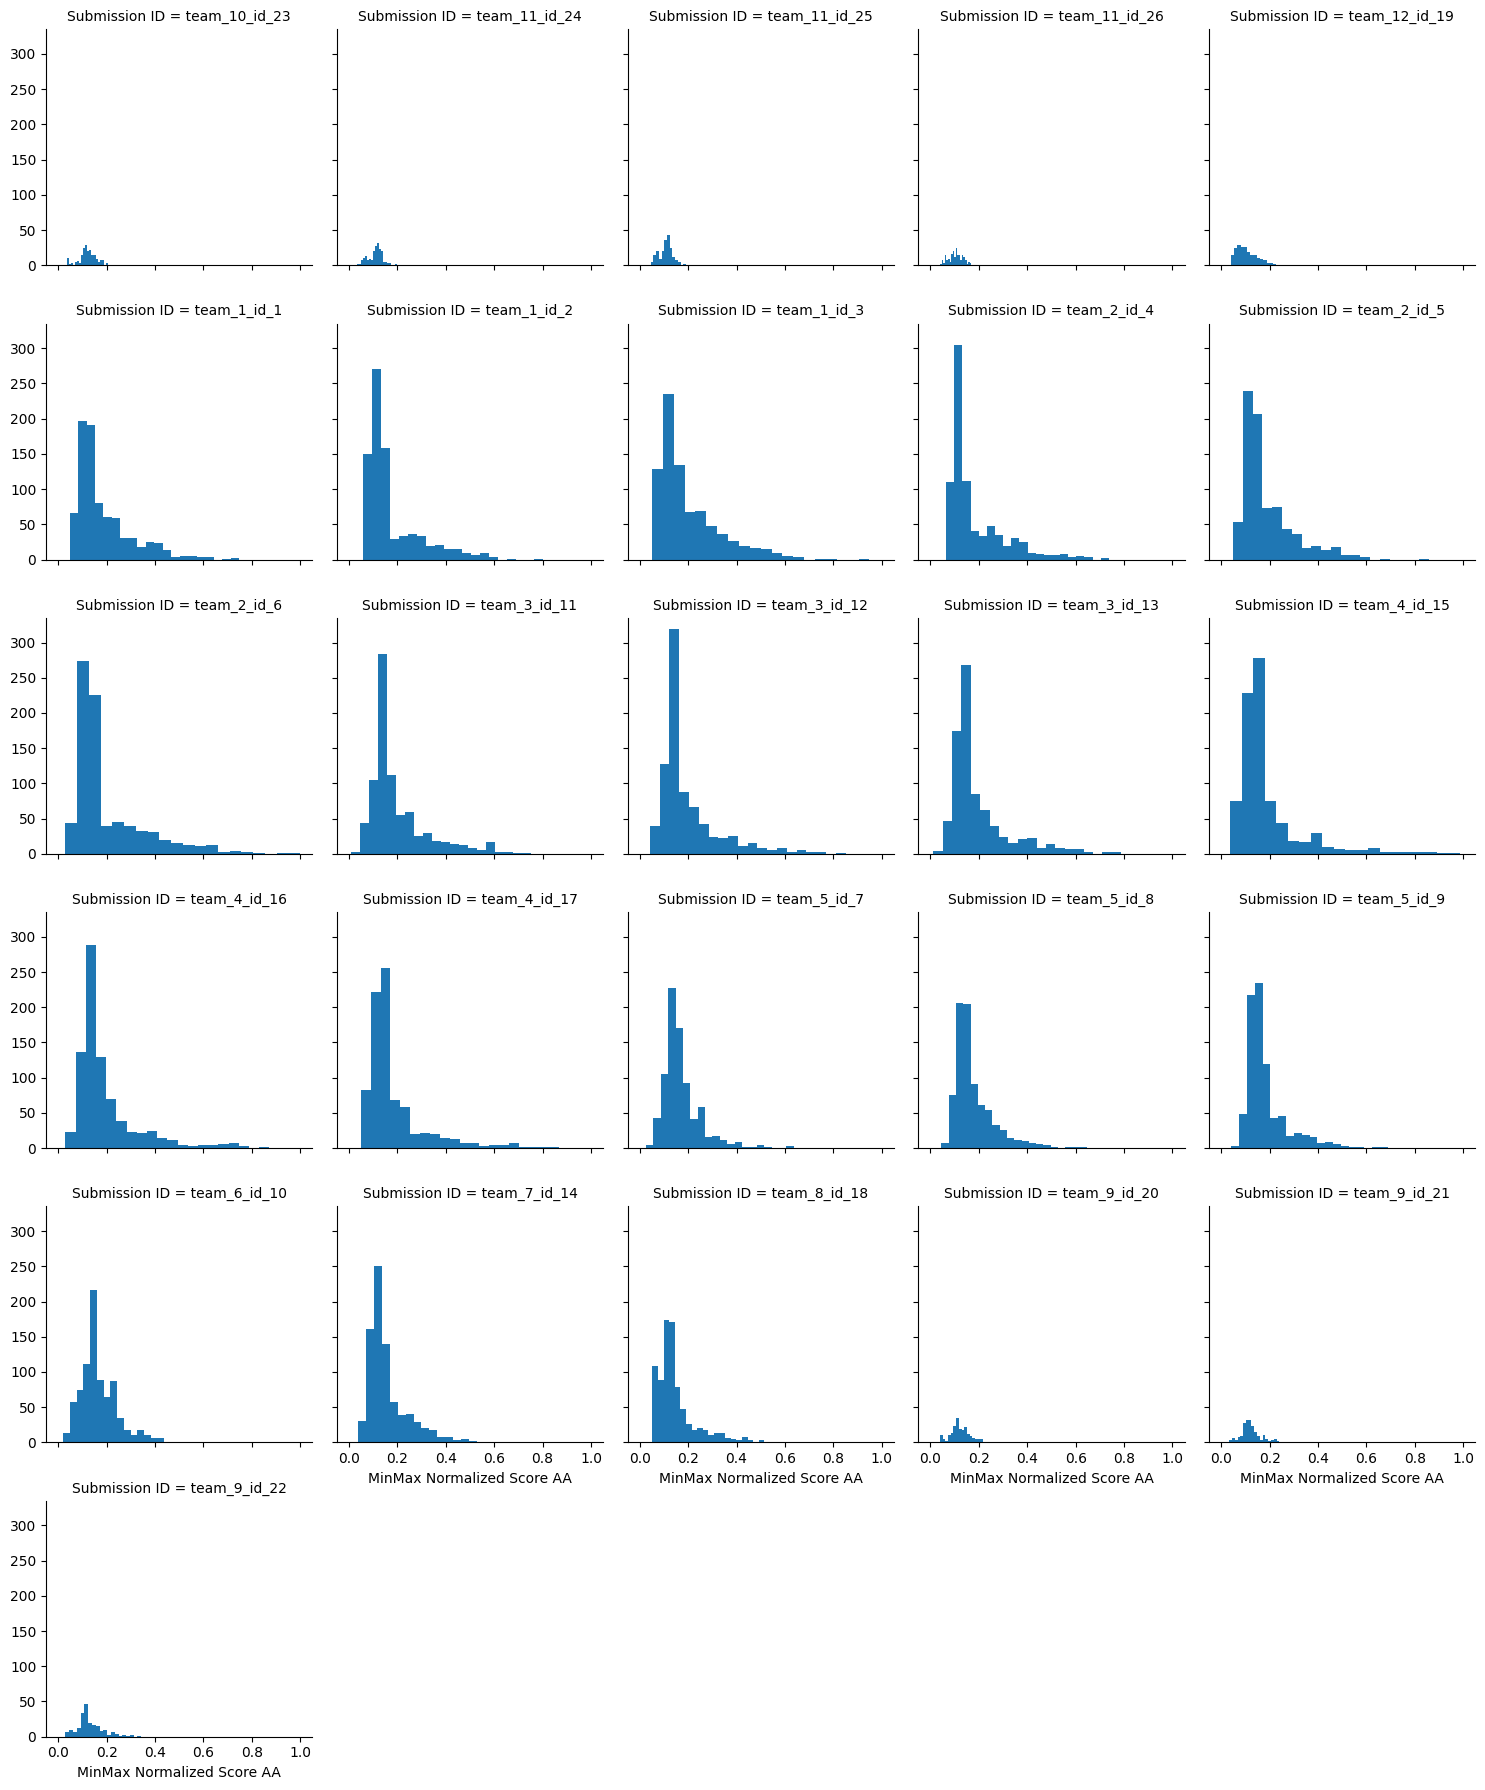

In [80]:
g = sns.FacetGrid(competition_data_df, col="Submission ID", col_wrap=5)
score = 'MinMax Normalized Score AA'
# Map the histogram to each facet
save = False
g.map(plt.hist, score, bins=20)
if save:
  filename = "/content/drive/MyDrive/Colab Notebooks/Melting pot/Competition data/original_score_distributions_by_agent.png"
  plt.savefig(filename, dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

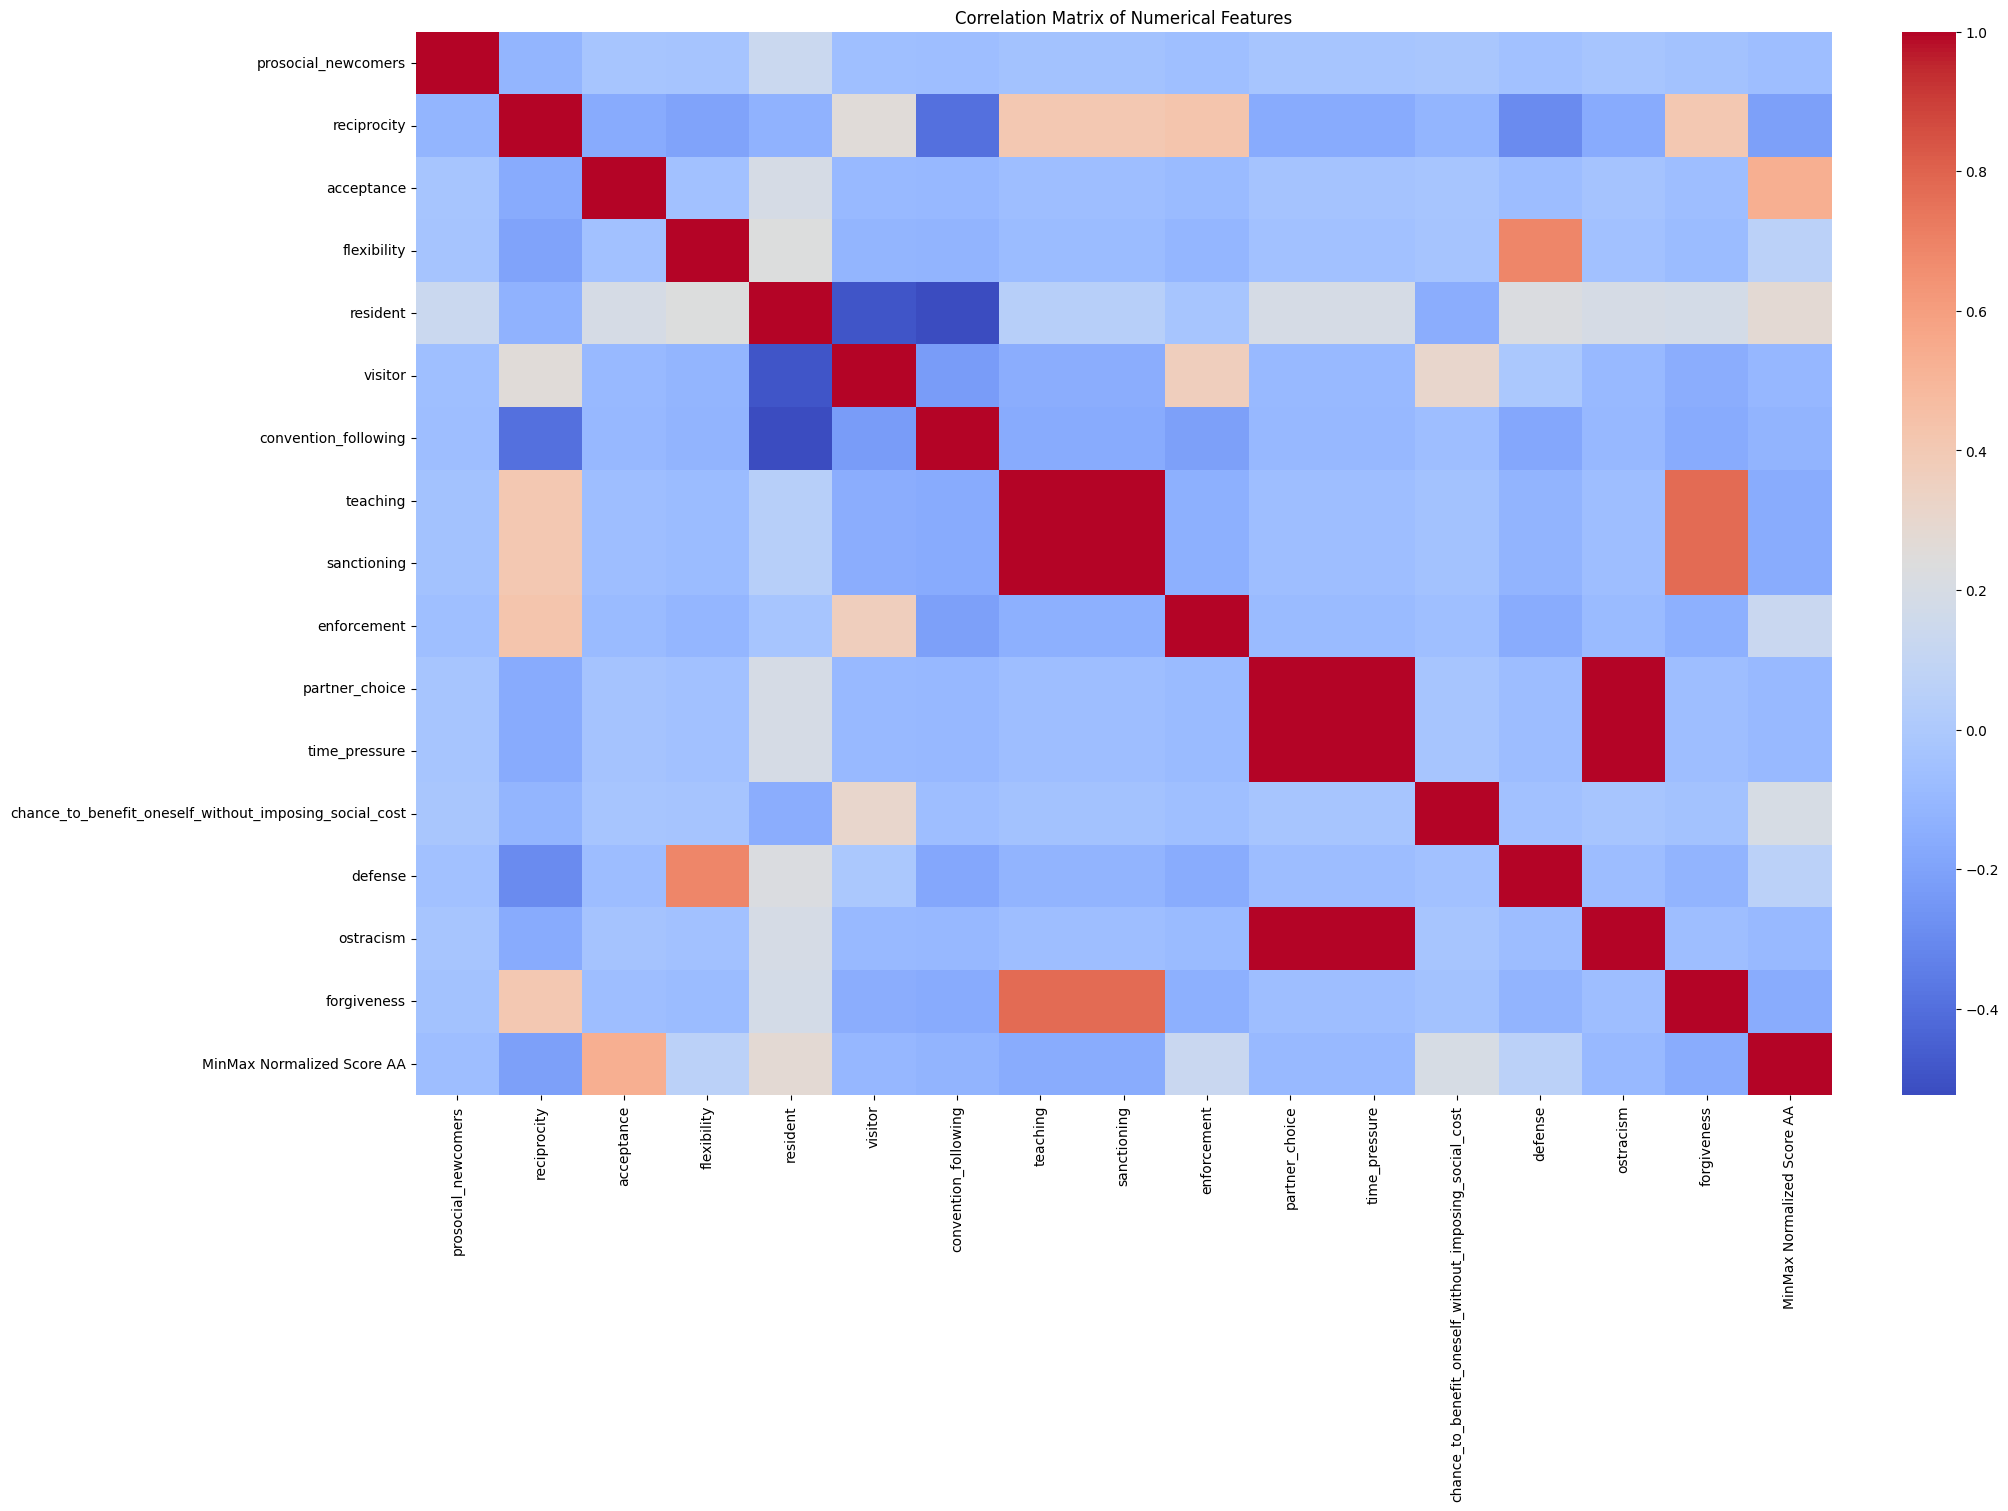

In [81]:
categorical_cols = ['Submission ID']  # Explicitly define categorical columns
binary_cols = [col for col in all_data.columns if all_data[col].dropna().isin(['Y', 'N']).all()]
# Select numerical columns (all except categorical)
numerical_cols = [col for col in competition_data_df.columns if col not in categorical_cols]

score = 'MinMax Normalized Score AA' #'MinMax Score AA'
# Calculate the correlation matrix
correlation_matrix = competition_data_df[binary_cols + [score]].corr() #numerical_cols
save = False
plt.figure(figsize=(20, 15))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".3f")
if save:
  filename = "/content/drive/MyDrive/Colab Notebooks/Melting pot/Competition data/tag_correlation_matrix.png"
  plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

### Find features

In [84]:
# Assuming 'binary_cols' is your list of binary columns and 'all_data' is your DataFrame
identical_cols = []
for i in range(len(binary_cols)):
    for j in range(i + 1, len(binary_cols)):
        col1 = binary_cols[i]
        col2 = binary_cols[j]
        if pd.Series.equals(all_data[col1], all_data[col2]):  # Check if columns are identical
            identical_cols.append((col1, col2))

print("Identical Columns:", identical_cols)

Identical Columns: [('teaching', 'sanctioning'), ('partner_choice', 'time_pressure'), ('partner_choice', 'ostracism'), ('time_pressure', 'ostracism')]


In [89]:
counts = competition_data_df["Submission ID"].value_counts()
top_agents = counts[counts == counts.max()].index.tolist()
top_agents

['team_2_id_4',
 'team_1_id_1',
 'team_2_id_5',
 'team_1_id_2',
 'team_1_id_3',
 'team_4_id_15',
 'team_3_id_13',
 'team_3_id_12',
 'team_3_id_11',
 'team_2_id_6',
 'team_5_id_8',
 'team_5_id_9',
 'team_6_id_10',
 'team_7_id_14',
 'team_8_id_18',
 'team_4_id_16',
 'team_4_id_17',
 'team_5_id_7']

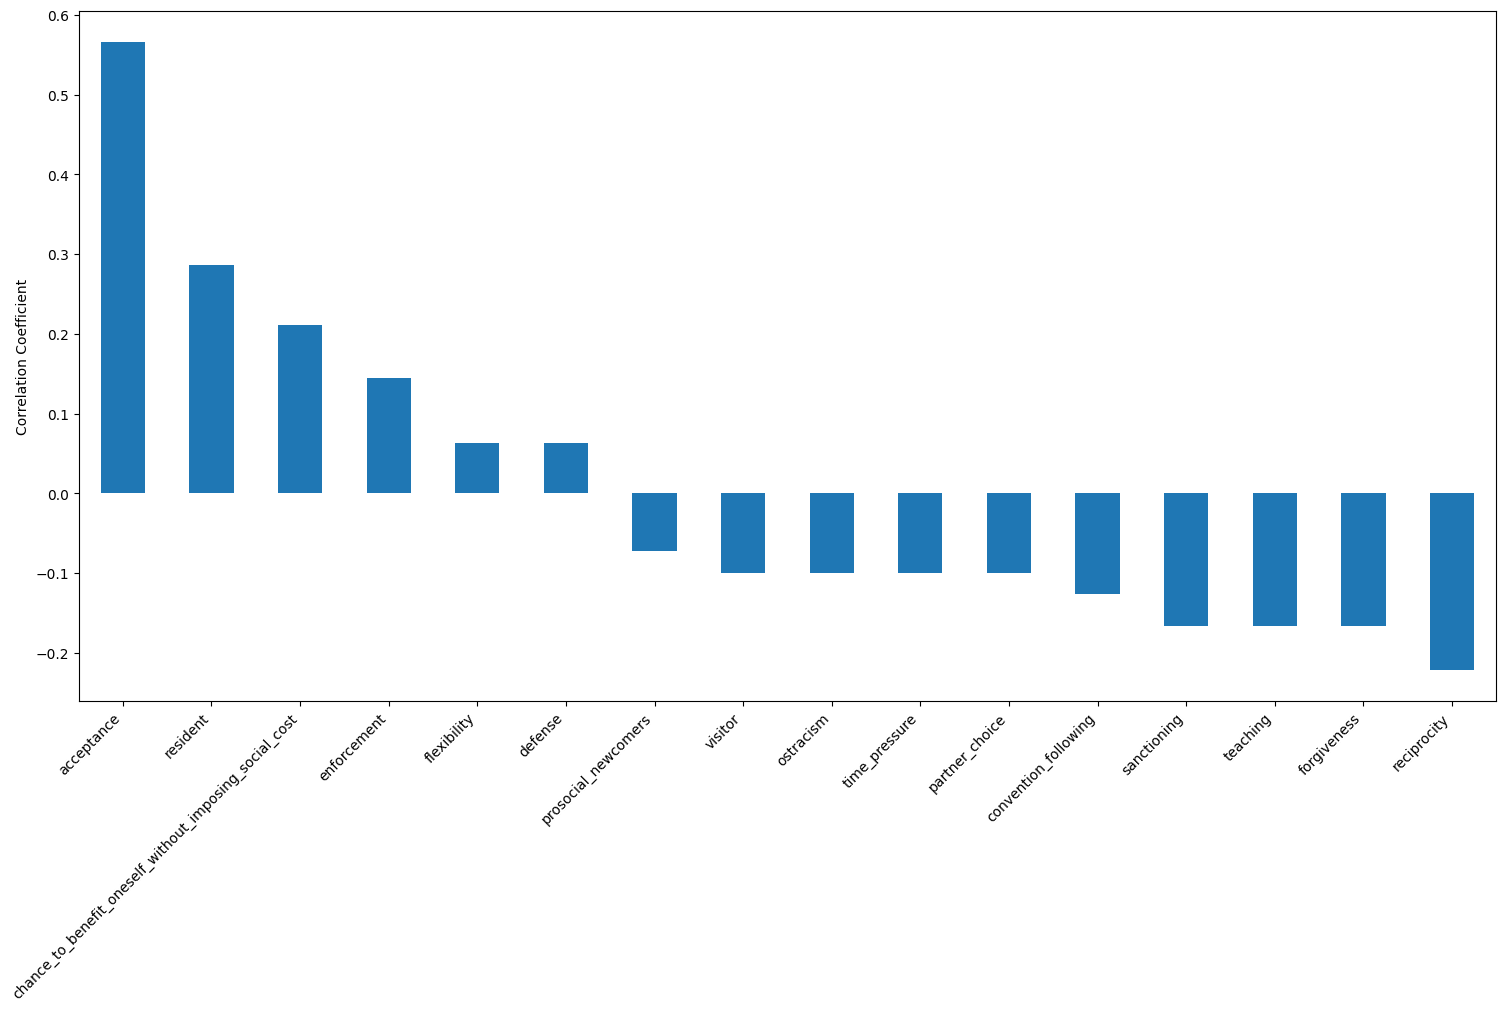

In [91]:
score = 'MinMax Normalized Score AA'

binary_cols = [col for col in all_data.columns if all_data[col].dropna().isin(['Y', 'N']).all()]
top_agents_df = competition_data_df[competition_data_df['Submission ID'].isin(top_agents)]
# Calculate the correlation matrix
correlation_matrix = top_agents_df[binary_cols + [score]].corr() #numerical_cols

score_correlations = correlation_matrix[score]
sorted_correlations = score_correlations.drop(score).sort_values(ascending=False)
save = False
# Plot the correlations
plt.figure(figsize=(15, 10))
sorted_correlations.plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation Coefficient')
if save:
  filename = "/content/drive/MyDrive/Colab Notebooks/Melting pot/Competition data/correlations_with_score.png"
  plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

In [92]:
negatively_correlated_cols = sorted_correlations[sorted_correlations < 0].index.tolist()
negatively_correlated_cols

['prosocial_newcomers',
 'visitor',
 'ostracism',
 'time_pressure',
 'partner_choice',
 'convention_following',
 'sanctioning',
 'teaching',
 'forgiveness',
 'reciprocity']

In [93]:
identical_cols

[('teaching', 'sanctioning'),
 ('partner_choice', 'time_pressure'),
 ('partner_choice', 'ostracism'),
 ('time_pressure', 'ostracism')]

In [94]:
exclude_cols = ['sanctioning', 'partner_choice', 'ostracism']
common_features_aggregate = [col for col in negatively_correlated_cols if col not in exclude_cols]
common_features_aggregate

['prosocial_newcomers',
 'visitor',
 'time_pressure',
 'convention_following',
 'teaching',
 'forgiveness',
 'reciprocity']

## Train/test split

In [95]:
competition_train_df, competition_test_df = train_test_split(competition_data_df,
                                                             test_size=0.2,
                                                             random_state=42,
                                                             stratify=competition_data_df[['Submission ID','Substrate Name']])

## Assessors

In [100]:
def train_and_evaluate_models(train, test, common_features, score, agents, plot_predictions = False):
    results = {}
    #for agent, train_data in train_dict.items():
    for agent in agents:
        df_train = train[train['Submission ID'] == agent]
        df_test = test[test['Submission ID'] == agent]
        X_train = df_train[common_features]
        y_train = df_train[score]
        X_test = df_test[common_features]
        y_test = df_test[score]

        # Baseline: Mean prediction
        mean_score = y_train.mean()
        baseline_predictions = [mean_score] * len(y_test)
        results[f'{agent}_meanScore_mse'] = mean_squared_error(y_test, baseline_predictions)
        results[f'{agent}_meanScore_rmse'] = root_mean_squared_error(y_test, baseline_predictions)
        results[f'{agent}_meanScore_r2'] = r2_score(y_test, baseline_predictions)

        results_b = pd.DataFrame({'True Values': y_test, 'Predictions': baseline_predictions})

        if plot_predictions:
          plt.figure(figsize=(10, 6))
          ax = sns.scatterplot(data=results_b, x='True Values', y='Predictions', alpha=0.5)

          # Add a diagonal line
          max_value = max(results_b['True Values'].max(), results_b['Predictions'].max())
          min_value = min(results_b['True Values'].min(), results_b['Predictions'].min())
          plt.plot([min_value, max_value], [min_value, max_value], '--k')

          # Adding labels and title
          plt.xlabel('True Values')
          plt.ylabel('Predictions')
          plt.title(f'True vs Predicted Values: baseline, {agent}')

          # Show the plot
          plt.show()

        # Linear Regression
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        lr_predictions = lr_model.predict(X_test)
        results[f'{agent}_lr_mse'] = mean_squared_error(y_test, lr_predictions)
        results[f'{agent}_lr_rmse'] = root_mean_squared_error(y_test, lr_predictions)
        results[f'{agent}_lr_r2'] = r2_score(y_test, lr_predictions)

        results_lr = pd.DataFrame({'True Values': y_test, 'Predictions': lr_predictions})

        if plot_predictions:
          plt.figure(figsize=(10, 6))
          ax = sns.scatterplot(data=results_lr, x='True Values', y='Predictions', alpha=0.5)

          # Add a diagonal line
          max_value = max(results_lr['True Values'].max(), results_lr['Predictions'].max())
          min_value = min(results_lr['True Values'].min(), results_lr['Predictions'].min())
          plt.plot([min_value, max_value], [min_value, max_value], '--k')

          # Adding labels and title
          plt.xlabel('True Values')
          plt.ylabel('Predictions')
          plt.title(f'True vs Predicted Values: linear regression, {agent}')

          # Show the plot
          plt.show()

        # XGBoost
        xgb_model = XGBRegressor()
        xgb_model.fit(X_train, y_train)
        xgb_predictions = xgb_model.predict(X_test)
        results[f'{agent}_xgb_mse'] = mean_squared_error(y_test, xgb_predictions)
        results[f'{agent}_xgb_rmse'] = root_mean_squared_error(y_test, xgb_predictions)
        results[f'{agent}_xgb_r2'] = r2_score(y_test, xgb_predictions)

        results_xgb = pd.DataFrame({'True Values': y_test, 'Predictions': xgb_predictions})

        if plot_predictions:
          plt.figure(figsize=(10, 6))
          ax = sns.scatterplot(data=results_xgb, x='True Values', y='Predictions', alpha=0.5)

          # Add a diagonal line
          max_value = max(results_xgb['True Values'].max(), results_xgb['Predictions'].max())
          min_value = min(results_xgb['True Values'].min(), results_xgb['Predictions'].min())
          plt.plot([min_value, max_value], [min_value, max_value], '--k')

          # Adding labels and title
          plt.xlabel('True Values')
          plt.ylabel('Predictions')
          plt.title(f'True vs Predicted Values: xgb, {agent}')

          # Show the plot
          plt.show()

        # TabPFN
        tabFPN_model = TabPFNRegressor()
        tabFPN_model.fit(X_train, y_train)
        tabFPN_predictions = tabFPN_model.predict(X_test)
        results[f'{agent}_tabFPN_mse'] = mean_squared_error(y_test, tabFPN_predictions)
        results[f'{agent}_tabFPN_rmse'] = root_mean_squared_error(y_test, tabFPN_predictions)
        results[f'{agent}_tabFPN_r2'] = r2_score(y_test, tabFPN_predictions)

        results_tabFPN = pd.DataFrame({'True Values': y_test, 'Predictions': tabFPN_predictions})

        if plot_predictions:
          plt.figure(figsize=(10, 6))
          ax = sns.scatterplot(data=results_tabFPN, x='True Values', y='Predictions', alpha=0.5)

          # Add a diagonal line
          max_value = max(results_tabFPN['True Values'].max(), results_tabFPN['Predictions'].max())
          min_value = min(results_tabFPN['True Values'].min(), results_tabFPN['Predictions'].min())
          plt.plot([min_value, max_value], [min_value, max_value], '--k')

          # Adding labels and title
          plt.xlabel('True Values')
          plt.ylabel('Predictions')
          plt.title(f'True vs Predicted Values: xgb, {agent}')

          # Show the plot
          plt.show()

    return results

In [99]:
score = 'MinMax Normalized Score AA'
mean_score = aggregated_data.groupby('Submission ID')[score].mean().sort_values(ascending=False)

sorted_agents_norm_score = mean_score.index.values
sorted_agents_norm_score

array(['team_2_id_6', 'team_1_id_3', 'team_3_id_12', 'team_3_id_11',
       'team_3_id_13', 'team_4_id_16', 'team_2_id_5', 'team_2_id_4',
       'team_4_id_15', 'team_1_id_1', 'team_4_id_17', 'team_5_id_9',
       'team_5_id_8', 'team_1_id_2', 'team_5_id_7', 'team_6_id_10',
       'team_7_id_14', 'team_8_id_18', 'team_9_id_22', 'team_9_id_21',
       'team_10_id_23', 'team_9_id_20', 'team_11_id_24', 'team_11_id_25',
       'team_12_id_19', 'team_11_id_26'], dtype=object)

In [ ]:
results_minmax_normalized_score_aa = train_and_evaluate_models(competition_train_df, competition_test_df,
                                                               common_features=common_features_aggregate,
                                                               score='MinMax Normalized Score AA',
                                                               agents=sorted_agents_norm_score)

/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:101: UserWarning: Downloading model to /root/.cache/tabpfn/tabpfn-v2-regressor.ckpt.
  model, bardist, config_ = load_model_criterion_config(


tabpfn-v2-regressor.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:3453: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:3453: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:3453: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:3453: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1


In [ ]:
def process_results(results, agents, method_order):
    """
    Processes the results dictionary into a structured DataFrame.

    Args:
        results (dict): A dictionary with keys in the format "agent_modelType_metric" and corresponding values.
        agents (list): A list of agents to order the DataFrame.
        method_order (list): A custom order for the predictive methods.

    Returns:
        pd.DataFrame: A processed and sorted DataFrame containing MSE, RMSE, and R2 for each agent and method.
    """
    data = []

    for key, value in results.items():
        parts = key.split("_")
        agent = "_".join(parts[:-2])  # Join all parts except the last two
        model_type = parts[-2]
        metric = parts[-1]
        data.append(
            {
                "predictive_method": model_type,
                "Agent": agent,
                "MSE": value if metric == "mse" else None,
                "RMSE": value if metric == "rmse" else None,
                "R2": value if metric == "r2" else None,
            }
        )

    df = pd.DataFrame(data)

    # Aggregate and sort
    results_df = df.groupby(["predictive_method", "Agent"])[["MSE", "RMSE", "R2"]].first().reset_index()
    results_df['predictive_method'] = pd.Categorical(results_df['predictive_method'], categories=method_order, ordered=True)
    results_df['Agent'] = pd.Categorical(results_df['Agent'], categories=agents, ordered=True)
    results_df = results_df.sort_values(by=['predictive_method', 'Agent'])

    return results_df

In [ ]:
assessors_minmax_normalized_score_aa  = process_results(results_minmax_normalized_score_aa,
                                                        agents = sorted_agents_norm_score,
                                                        method_order = ['meanScore', 'lr', 'xgb','tabFPN'])

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

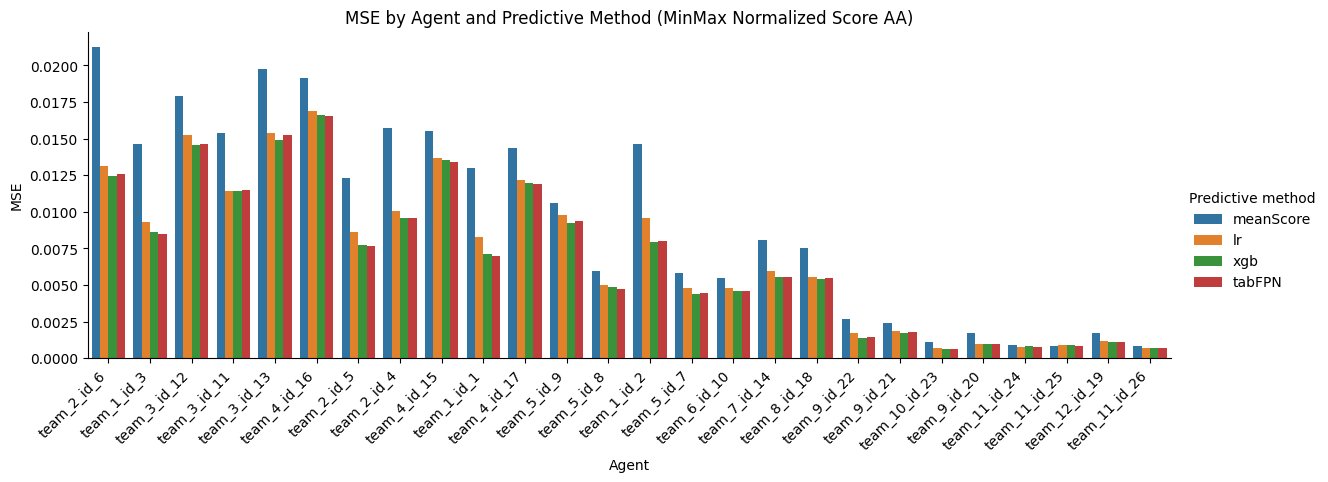

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

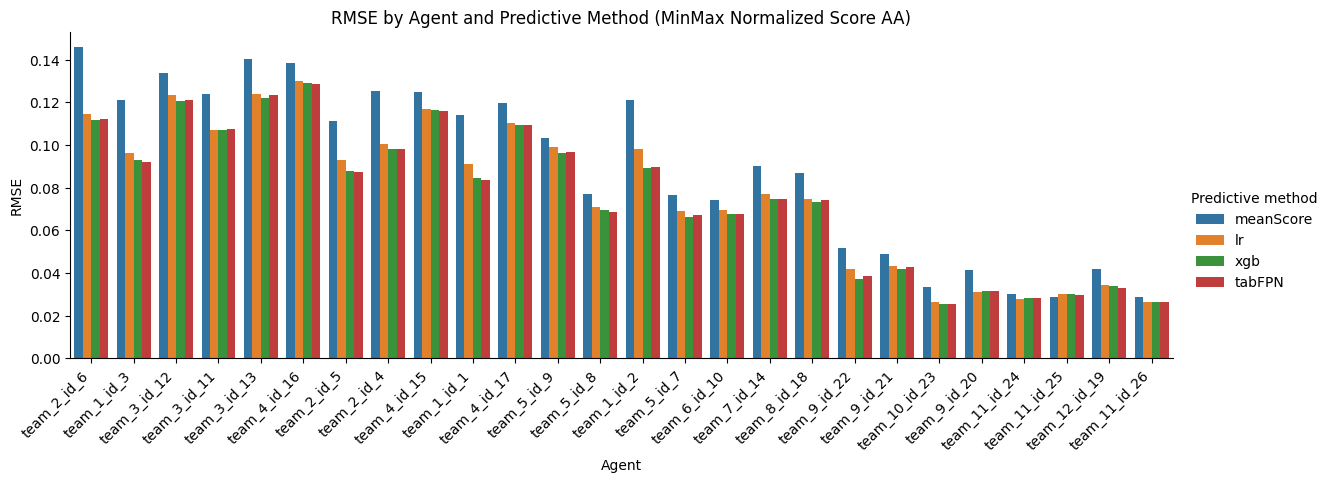

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

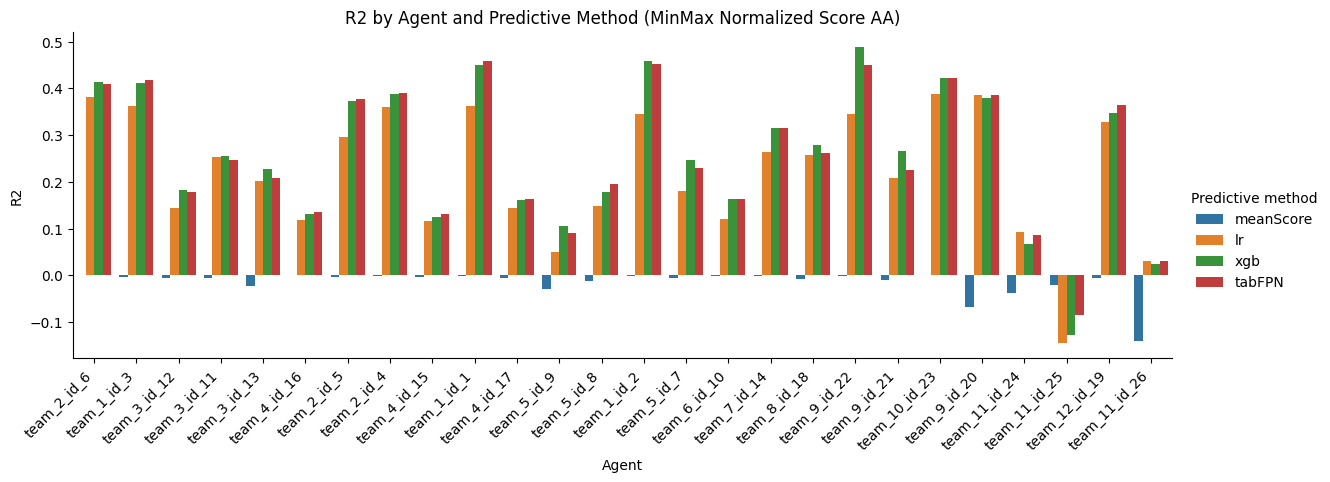

In [ ]:
for metric in ["MSE", "RMSE", "R2"]:
    plt.figure(figsize=(10, 6))
    g = sns.catplot(x="Agent", y=metric, hue="predictive_method", data=assessors_minmax_normalized_score_aa, kind="bar", height=4, aspect=3, legend_out=True)
    plt.title(f"{metric} by Agent and Predictive Method (MinMax Normalized Score AA)")
    plt.xlabel("Agent")
    plt.ylabel(metric)
    g._legend.set_title('Predictive method')
    plt.xticks(rotation=45, ha='right')
    plt.show()

## Measurement layout

In [106]:
# Make predictions after training a measurement layout
def predict(m, trace, relevantData,var_name:str):
    """This only works if you re-instantiated the model with the test data"""
    with m:
        predictions = pm.sample_posterior_predictive(trace, var_names=[var_name], return_inferencedata=False,
                                                     predictions=True, extend_inferencedata=False)
        predictionChainRuns = predictions[var_name][:, :, 0:len(relevantData)]
        predictionsInstance = np.mean(predictionChainRuns, (0, 1))

        return predictionsInstance


#### Run model pipline function

In [107]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import brier_score_loss, roc_auc_score

def run_model_pipeline(train_df, test_df, model_func,feature_names,score_name,chance,distribution, draws, tune, target_accept, abilities = None, forestPlot = False, sample_method = 'CPU',*args):
    """
    Run the full pipeline for a given model: build, sample, evaluate, and predict.

    Parameters:
        train_df: Training data.
        test_df: Testing data.
        model_func (function): Function to initialize the model.

    Returns:
        dict: Results containing model metrics and trace.
    """
    # Step 1: Initialize Model
    print("\n\033[1m\033[34mInitializing model...\033[0m")
    model = model_func(train_df,feature_names=feature_names,score_name=score_name,chance=chance,distribution=distribution)
    g = pm.model_to_graphviz(model)
    display(g)

    # Step 2: Sample from Prior
    print("\n\033[1m\033[34mSampling from prior predictive...\033[0m")
    with model:
        prior_predictive = pm.sample_prior_predictive(samples=1_000)


    az.plot_ppc(prior_predictive,group='prior')
    plt.show()

    # Step 3: Sample Posterior
    print("\n\033[1m\033[34mSampling from posterior...\033[0m")
    if sample_method == 'CPU':
      with model:
          trace = pm.sample(draws=draws, tune=tune, target_accept=target_accept,)
    elif sample_method == 'GPU':
      with model:
          #trace = pm.sampling.jax.sample_numpyro_nuts(draws=draws, tune=tune, target_accept=target_accept,)
          trace = pm.sample(draws=draws, tune=tune, target_accept=target_accept, nuts_sampler="numpyro",)
          nuts_sampler="numpyro",
    else:
      raise ValueError("sample_method must be 'CPU' or 'GPU'")

    # Step 4: Posterior Predictive Sampling
    print("\n\033[1m\033[34mSampling from posterior predictive...\033[0m")
    with model:
        posterior_predictive = pm.sample_posterior_predictive(trace=trace)

    plt.hist(train_df[score_name].values, 50, histtype='step', color='b')
    all_predicted_values = np.concatenate(posterior_predictive.posterior_predictive['taskPerformance'])
    for mix in all_predicted_values[::50]:
      plt.hist(mix, 50, histtype='step',
                    color='r', alpha=0.01)
    plt.show()

    # Step 5: Analyze Trace
    print("\n\033[1m\033[34mAnalyzing trace...\033[0m")

    if abilities is None:
      abilities = [str(var) for var in model.value_vars]

    az.plot_trace(data=trace['posterior'][abilities])

    # Forest Plot for Selected Variables
    def plot_forest_subplots(trace, var_names, figsize=None, sharex=True):
        num_vars = len(var_names)
        if figsize is None:
            figsize = (8, 4 * num_vars)
        fig, axes = plt.subplots(num_vars, 1, figsize=figsize, sharex=sharex)

        if num_vars == 1:
            axes = [axes]

        for idx, var_name in enumerate(var_names):
            az.plot_forest(
                trace,
                var_names=[var_name],
                r_hat=False,
                combined=True,
                labeller=az.labels.NoVarLabeller(),
                ax=axes[idx],
            )
            axes[idx].set_title(f"Forest Plot for {var_name}")

        plt.tight_layout()
        plt.show()

    if forestPlot == 'subplots':
      forest_abilities = [ability for ability in abilities if ability != 'sampleSize']
      plot_forest_subplots(trace=trace, var_names=forest_abilities)

    elif forestPlot == 'single':
      forest_abilities = [ability for ability in abilities if ability != 'sampleSize']
      az.plot_forest(
                trace,
                var_names=forest_abilities,
                r_hat=False,
                combined=True,
                labeller=az.labels.NoVarLabeller(),
            )
      plt.show()
    else:
      raise ValueError("Invalid forest plot specified")

    az.plot_energy(data=trace)
    az.plot_posterior(data=trace['posterior'][abilities])
    print(az.summary(trace['posterior'][abilities], round_to=3))

    # Step 6: Test Predictions and Evaluation
    print("\n\033[1m\033[34mEvaluating on test data...\033[0m")
    model_initialize = model_func(test_df,feature_names=feature_names,score_name=score_name,chance=chance,distribution=distribution)
    predictions = predict(model_initialize, trace, test_df[feature_names], var_name='taskPerformance')

    mse_mes_lay = mean_squared_error(test_df[score_name], predictions)
    rmse_mes_lay = root_mean_squared_error(test_df[score_name], predictions)
    r2_mes_lay = r2_score(test_df[score_name], predictions)

    print(f'MSE: {mse_mes_lay:.4f}, \n'
          f'RMSE: {rmse_mes_lay:.4f}, \n'
          f'R-squared: {r2_mes_lay:.4f}')

    return {
        "trace": trace,
        "metrics": {
            "MSE": mse_mes_lay,
            "RMSE": rmse_mes_lay,
            "R-squared": r2_mes_lay,
        }
    }

### Measurement layout model

In [102]:
def format_ability_name(name):
      # Replace underscores with no space and capitalize the following letter
      formatted = ''.join(word.capitalize() for word in name.split('_'))
      return 'ability' + formatted

In [143]:
def BetaPrior(df,feature_names,
              score_name,
              chance: bool = True,
              base_chance_fixed: float = 0.99,
              distribution='Beta'):

  with pm.Model() as m:

    response = df[score_name]
    response_max = df[score_name].max()
    features = df[feature_names]

    # Abilities
    abilities = {
            name: pm.Beta(format_ability_name(name), alpha=2, beta=2) for name in feature_names
        }

    ability_tensor = pm.math.stack([abilities[name] for name in feature_names])

    # Data container for demands
    demands = pm.Data("demands", features)

    # Base chance
    if chance:
      base_chance = pm.Beta('base_chance',alpha=5,beta=1)
    else:
      base_chance = pm.Deterministic("base_chance", base_chance_fixed)

    # Local performance
    localPerformance = pm.Deterministic(
            "localPerformance", (1 - demands) * base_chance + demands * ability_tensor
        )
    # Integrated performance
    integratedP = pm.Deterministic("integratedP", pm.math.prod(localPerformance, axis=1))

    #Beta likelihood
    if distribution == 'Beta':
      response = np.clip(response, 0.0001, 1 - 0.0001)  # Ensure response values are valid
      sampleSize = pm.HalfNormal('sampleSize', sigma=5)
      taskPerformance = pm.Beta("taskPerformance", mu=integratedP, nu=sampleSize, observed=response)
    else:
      raise ValueError("Invalid distribution specified")
  return m

### Visualise measurement layout

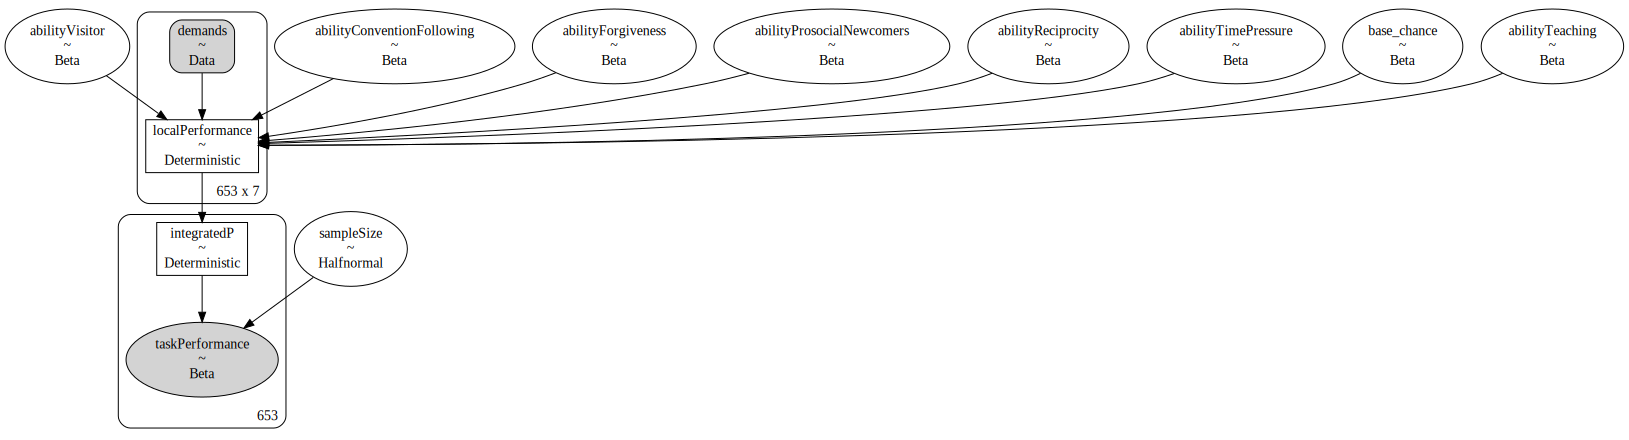

In [144]:
agent = 'team_2_id_6'
score = 'MinMax Normalized Score AA'
dist = 'Beta'
m_melting_pot = BetaPrior(competition_train_df[competition_train_df['Submission ID'] == agent],
                          feature_names=common_features_aggregate,
                          score_name=score,chance=True,
                          distribution=dist)
gv = pm.model_to_graphviz(m_melting_pot)
#gv.render(filename="/content/drive/MyDrive/Colab Notebooks/Melting pot/Competition data/mes_layout.png", format='png')
gv

### Single agent example


Initializing model...


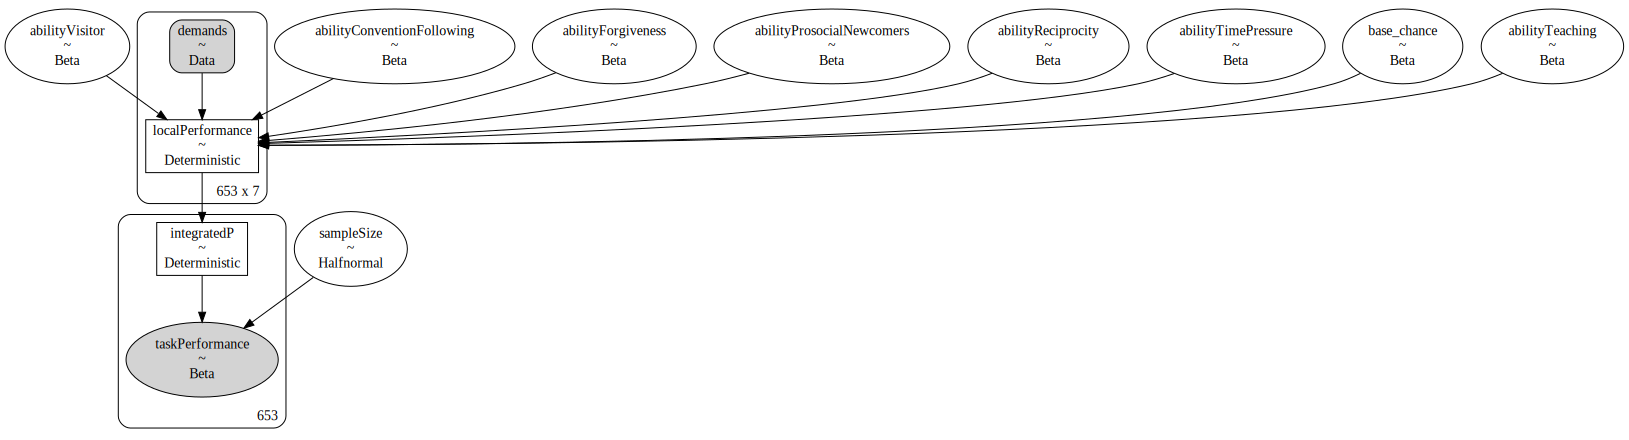


Sampling from prior predictive...


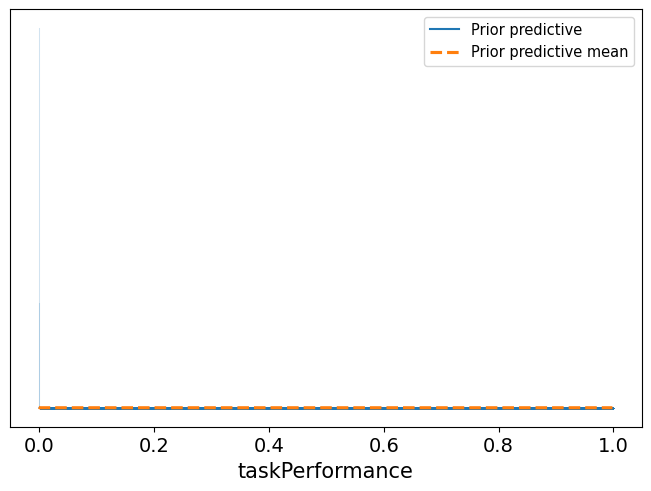


Sampling from posterior...


Output()

Output()


Sampling from posterior predictive...


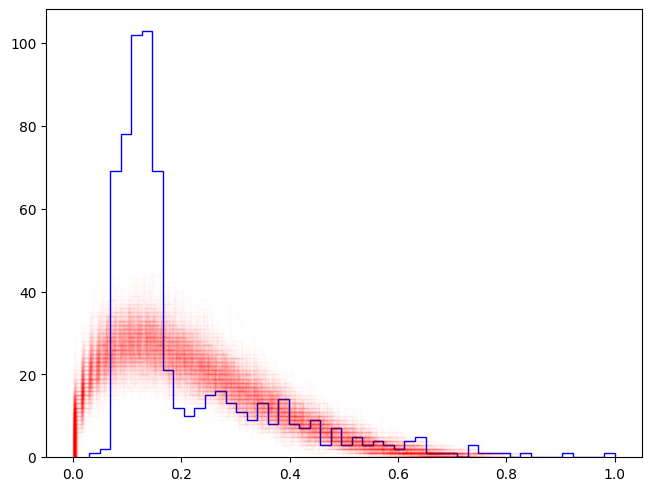


Analyzing trace...


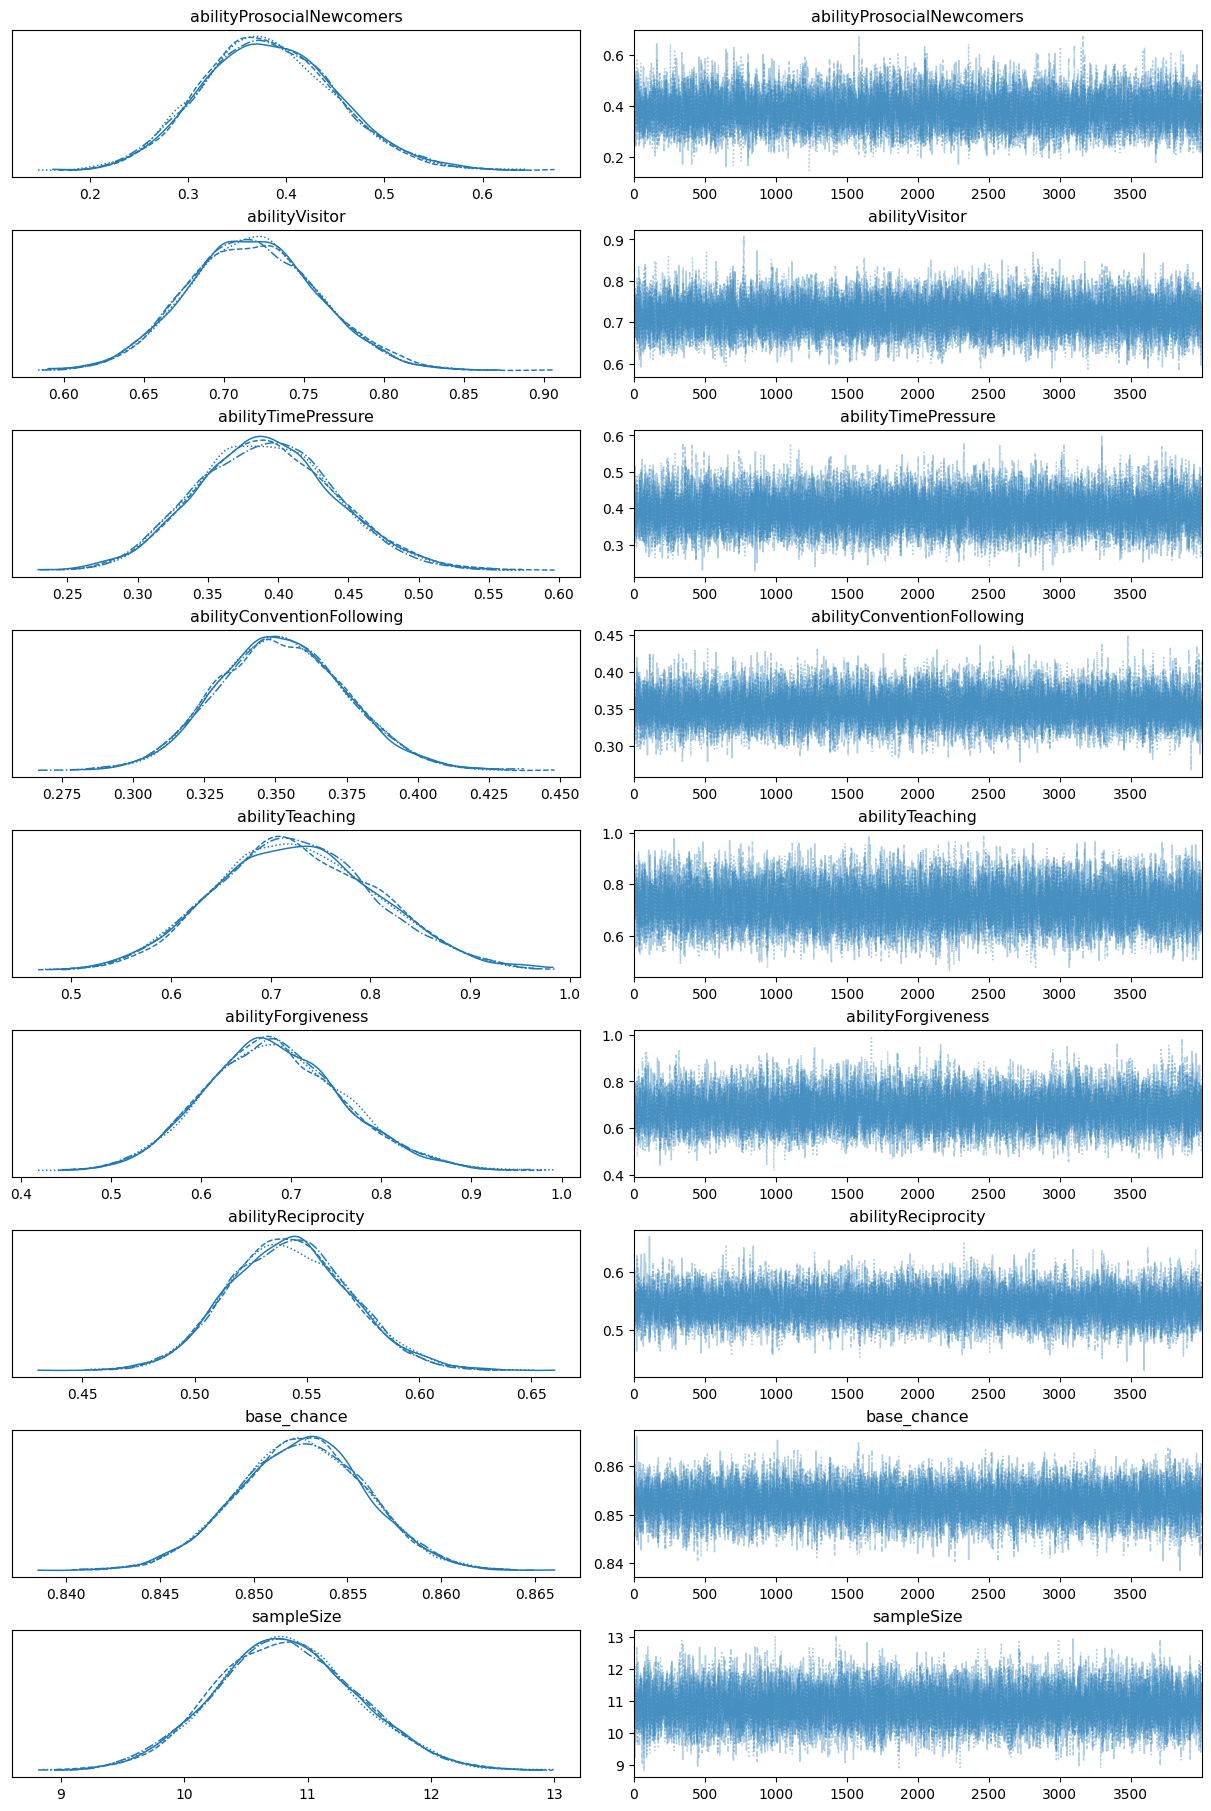

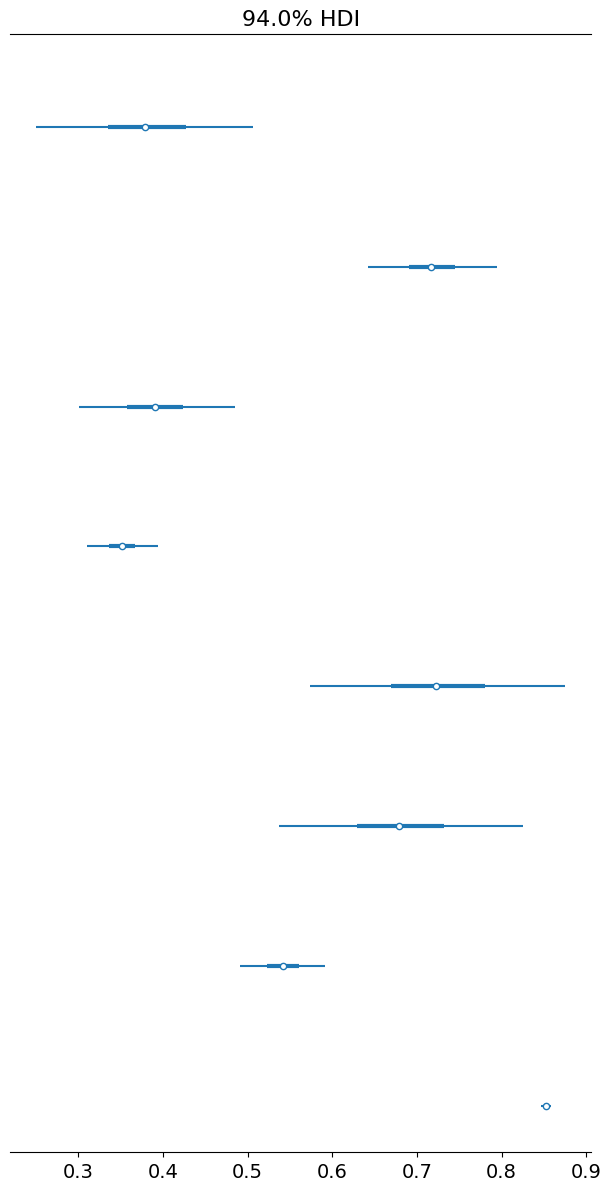

Output()

                              mean     sd  hdi_3%  hdi_97%  mcse_mean  \
abilityProsocialNewcomers    0.382  0.068   0.250    0.507      0.001   
abilityVisitor               0.718  0.041   0.642    0.795      0.000   
abilityTimePressure          0.392  0.049   0.301    0.484      0.000   
abilityConventionFollowing   0.352  0.023   0.310    0.394      0.000   
abilityTeaching              0.726  0.081   0.574    0.875      0.001   
abilityForgiveness           0.682  0.077   0.537    0.826      0.001   
abilityReciprocity           0.542  0.027   0.491    0.592      0.000   
base_chance                  0.853  0.003   0.846    0.859      0.000   
sampleSize                  10.825  0.578   9.753   11.925      0.005   

                            mcse_sd   ess_bulk   ess_tail  r_hat  
abilityProsocialNewcomers     0.001  13324.518  10350.657    1.0  
abilityVisitor                0.000  12946.065   9332.039    1.0  
abilityTimePressure           0.000  14514.818  11876.861    1.0  
a

MSE: 0.0136, 
RMSE: 0.1165, 
R-squared: 0.3614


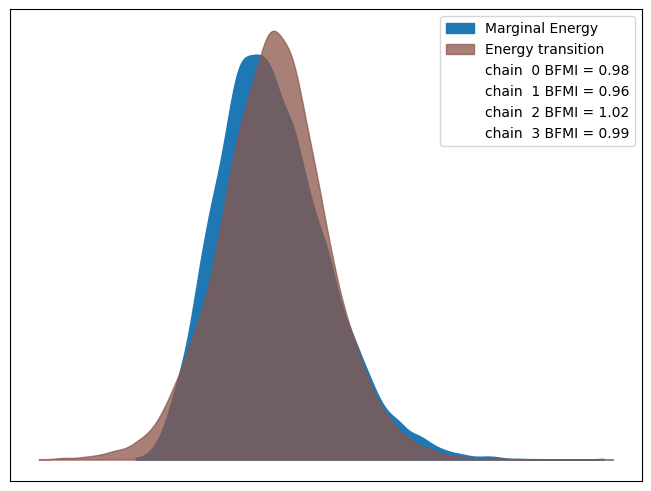

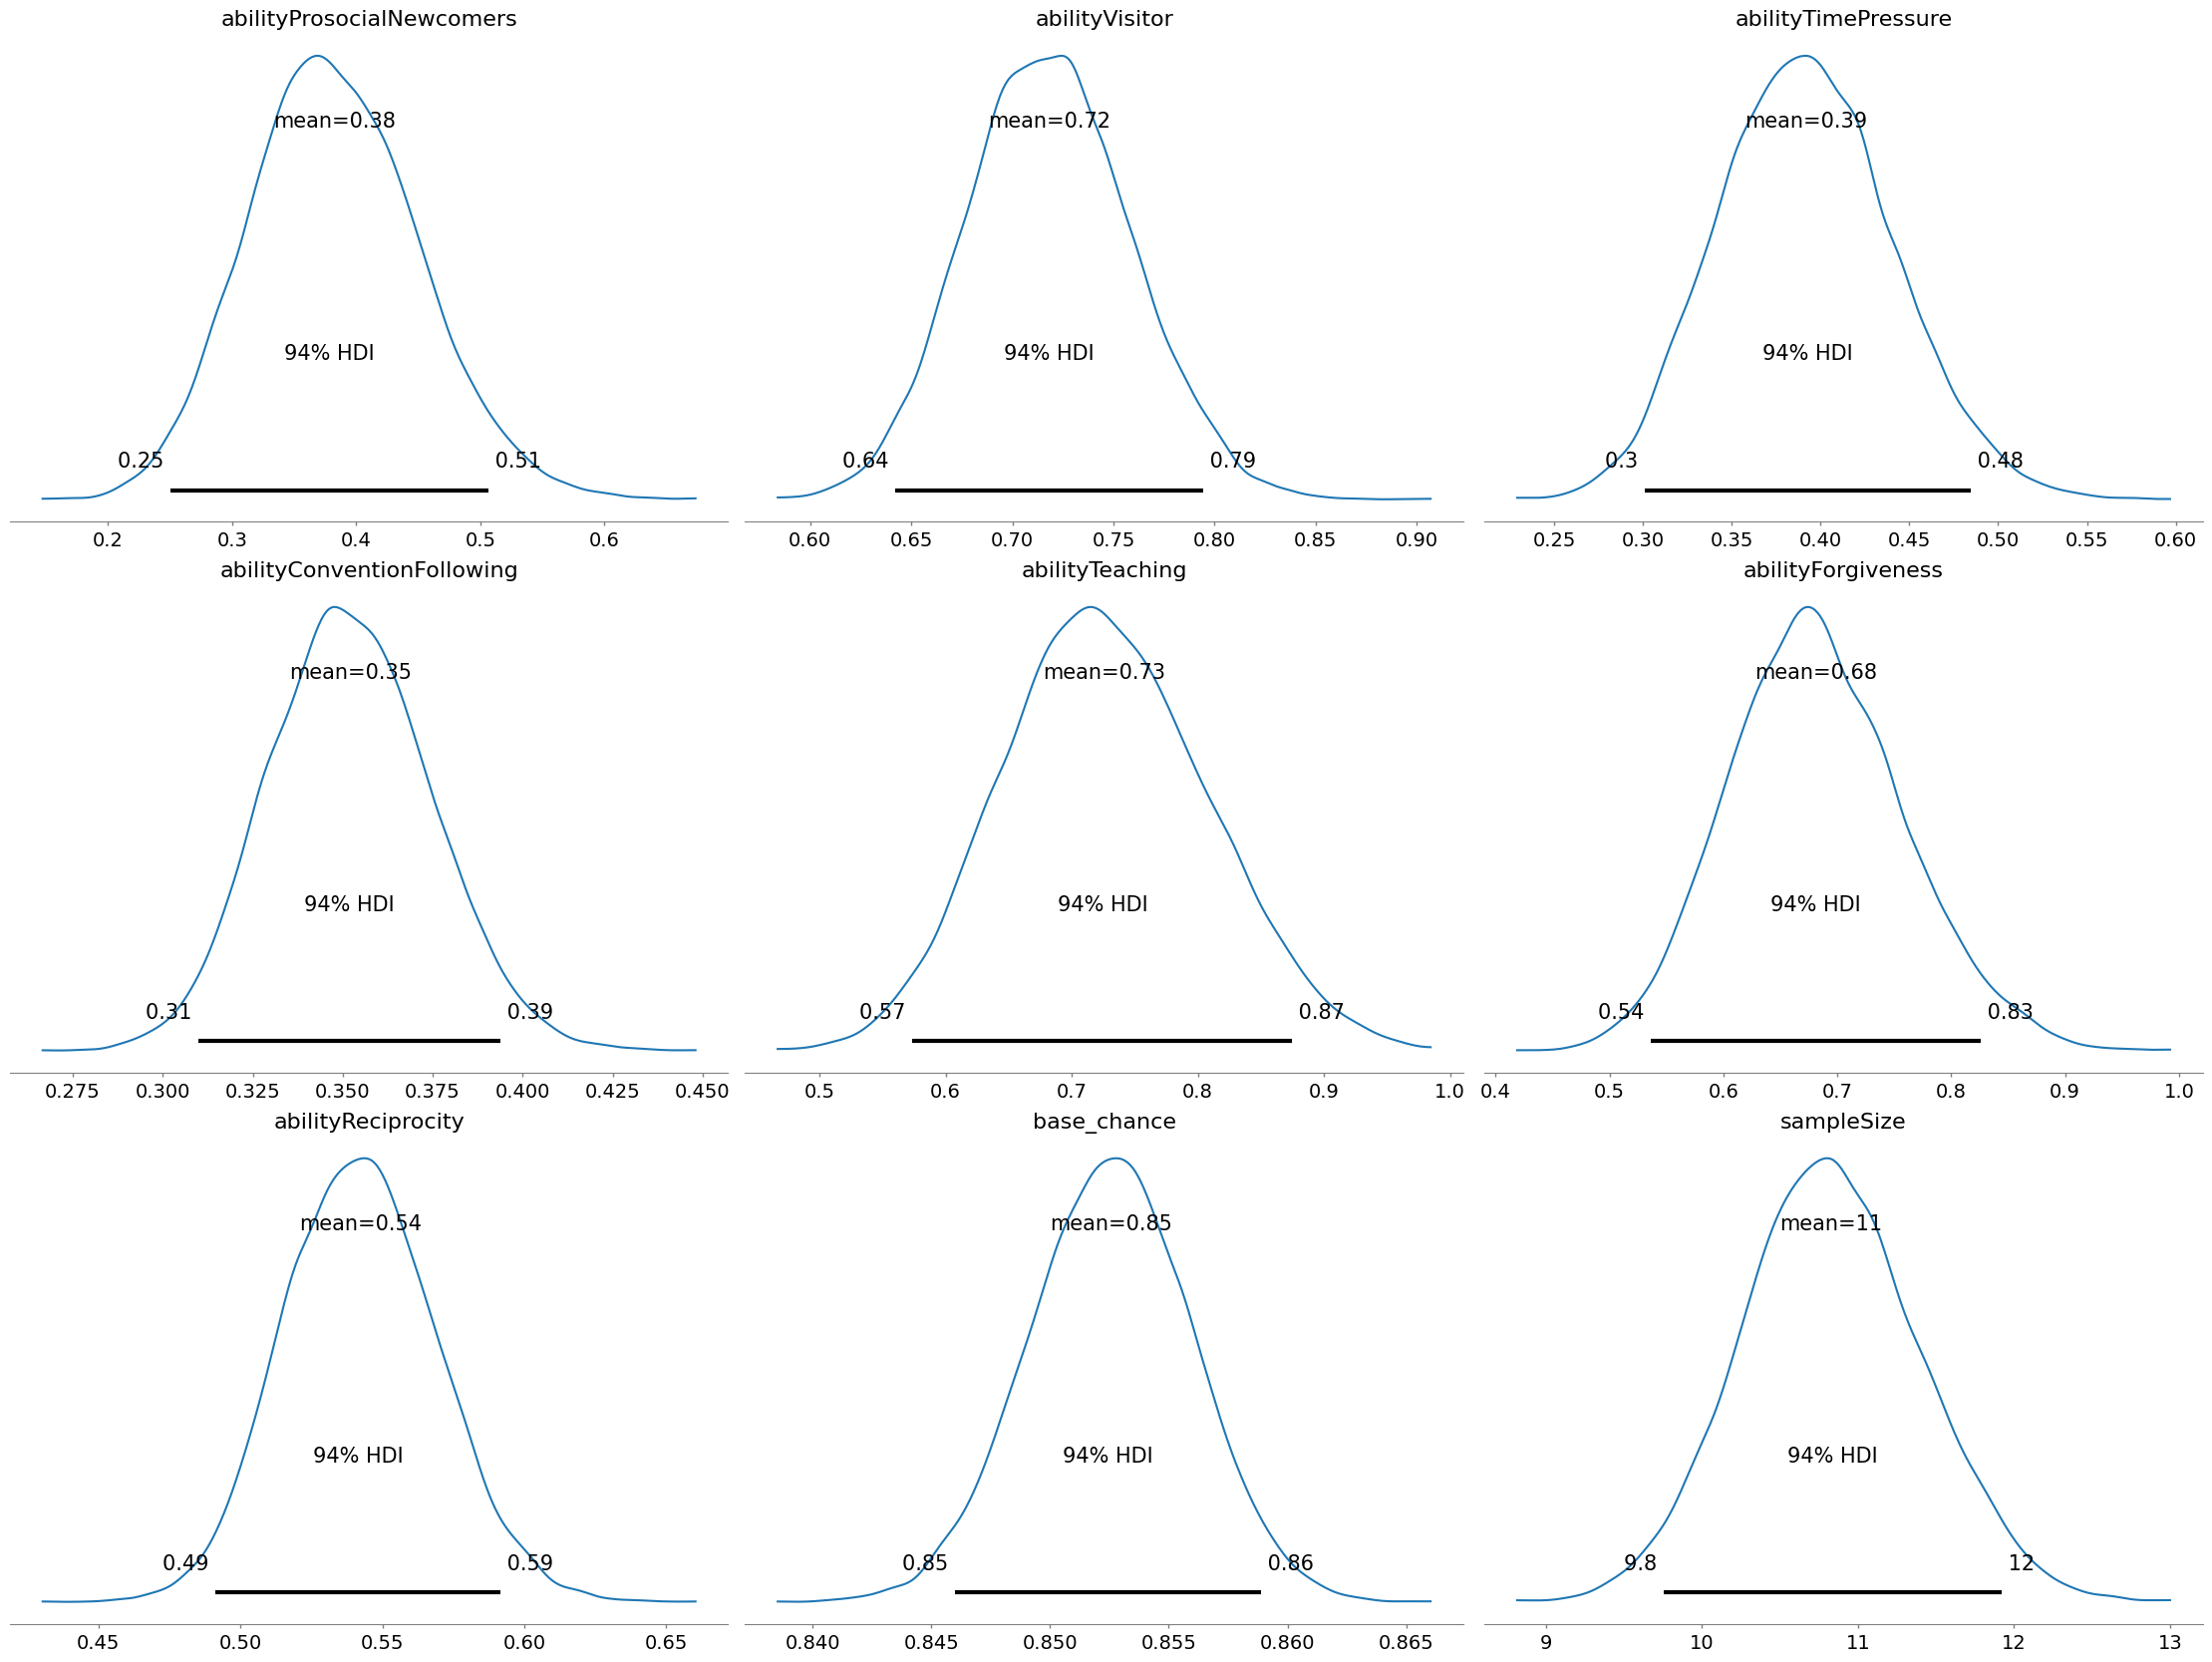

In [145]:
agent = 'team_2_id_6'
score = 'MinMax Normalized Score AA'
dist = 'Beta'

beta_prior_model = run_model_pipeline(train_df = competition_train_df[competition_train_df['Submission ID'] == agent],
                                      test_df = competition_test_df[competition_test_df['Submission ID'] == agent],
                                      model_func = BetaPrior,
                                      feature_names = common_features_aggregate,
                                      score_name = score,
                                      chance = True,
                                      distribution = dist,
                                      draws = 4000,
                                      tune = 1000,
                                      target_accept = 0.99,
                                      abilities = [format_ability_name(ability) for ability in common_features_aggregate] + ['base_chance','sampleSize'],# ['base_chance','sampleSize'],#'sd','alpha'],#+ ['sampleSize'], #+ ['base_chance'], #'sampleSize'[format_slope_name(slope) for slope in common_features_aggregate]
                                      forestPlot = 'single',
                                      sample_method = 'CPU')

### All agents

In [ ]:
def process_agents(agents, competition_train_df, competition_test_df, common_features, score, dist, other_parameters):
    metrics_dict = {}
    data_mes = []

    for i, agent in enumerate(agents):
        print(f'\nAgent: {agent} ({i + 1}/{len(agents)}), score: {score}, distribution: {dist}\n')

        metrics_dict[agent] = {}
        train_df = competition_train_df[competition_train_df['Submission ID'] == agent]

        # Model setup
        m_mes_lay = BetaPrior(train_df, feature_names=common_features, score_name=score, chance=True, distribution=dist)

        # Posterior sampling
        with m_mes_lay:
            mes_lay_trace = pm.sample(draws=4000, tune=1000, chains=4, target_accept=0.99)

        # Posterior predictive
        with m_mes_lay:
            posterior_predictive = pm.sample_posterior_predictive(trace=mes_lay_trace)

        # Plot posterior predictive
        plt.figure()
        plt.hist(train_df[score].values, 50, histtype='step', color='b')
        all_predicted_values = np.concatenate(posterior_predictive.posterior_predictive['taskPerformance'])
        for mix in all_predicted_values[::50]:
            plt.hist(mix, 50, histtype='step', color='r', alpha=0.01)

        plt.title(f'Posterior Predictive for {agent}')
        plt.xlabel('Task Performance')
        plt.ylabel('Frequency')
        plt.show()

        # Store parameter summary stats
        abilities = [format_ability_name(ability) for ability in common_features]
        all_parameters = abilities + other_parameters

        for par in all_parameters:
            summary = az.summary(mes_lay_trace['posterior'][par], round_to=3)
            metrics_dict[agent][par] = {
                'mean': summary['mean'].iloc[0],
                'hdi_3%': summary['hdi_3%'].iloc[0],
                'hdi_97%': summary['hdi_97%'].iloc[0],
                'ess_bulk': summary['ess_bulk'].iloc[0],
                'ess_tail': summary['ess_tail'].iloc[0],
                'r_hat': summary['r_hat'].iloc[0],
            }

        # Predict on test data
        test_df = competition_test_df[competition_test_df['Submission ID'] == agent]
        model_initialize = BetaPrior(test_df, feature_names=common_features, score_name=score, chance=True, distribution=dist)
        predictions = predict(model_initialize, mes_lay_trace, test_df[common_features], 'taskPerformance')

        # Performance metrics
        mse_mes_lay = mean_squared_error(test_df[score], predictions)
        rmse_mes_lay = root_mean_squared_error(test_df[score], predictions)
        r2_mes_lay = r2_score(test_df[score], predictions)

        data_mes.append({
            "predictive_method": f'Measurement layout ({dist} & {score})',
            "Agent": agent,
            "MSE": mse_mes_lay,
            "RMSE": rmse_mes_lay,
            "R2": r2_mes_lay,
        })

        print(f"MSE {agent}: {mse_mes_lay:.4f}")
        print(f"RMSE {agent}: {rmse_mes_lay:.4f}")
        print(f"R-squared {agent}: {r2_mes_lay:.4f}")

    # Convert metrics_dict to DataFrame
    rows = []
    for agent, parameters in metrics_dict.items():
        for param, stats in parameters.items():
            row = {
                'Agent': agent,
                'Parameter': param,
                'Mean': stats['mean'],
                'HDI 3%': stats['hdi_3%'],
                'HDI 97%': stats['hdi_97%'],
                'ESS Bulk': stats['ess_bulk'],
                'ESS Tail': stats['ess_tail'],
                'R Hat': stats['r_hat']
            }
            rows.append(row)

    metrics_df = pd.DataFrame(rows)
    print("\nMetrics Summary:")
    with pd.option_context('display.max_rows', None):
      display(metrics_df)

    return metrics_dict, data_mes, metrics_df

In [ ]:
def plot_metrics_and_summary(metrics_dict, data_mes, assessor_results, common_features, dist, score):
    # Combine results
    results_df_mes_lay = pd.concat([assessor_results, pd.DataFrame(data_mes)], ignore_index=True)
    display(results_df_mes_lay)

    # Plot metrics
    for metric in ["MSE", "RMSE", "R2"]:
        plt.figure(figsize=(10, 6))
        g = sns.catplot(x="Agent", y=metric, hue="predictive_method", data=results_df_mes_lay, kind="bar", height=4, aspect=3, legend_out=True)
        plt.title(f"{metric} by Agent and Predictive Method ({dist} & {score})")
        plt.xlabel("Agent")
        plt.ylabel(metric)
        g._legend.set_title('Predictive method')
        plt.xticks(rotation=45, ha='right')
        plt.show()

    # Metrics DataFrame for abilities
    rows = []
    for agent, abilities in metrics_dict.items():
        for ability, stats in abilities.items():
            rows.append({
                'Agent': agent,
                'Ability': ability,
                'Mean': stats['mean'],
                'Lower': stats['hdi_3%'],
                'Upper': stats['hdi_97%']
            })
    df = pd.DataFrame(rows)

    # Plot abilities using FacetGrid
    def plot_with_errorbars(data, **kwargs):
        errors = [data['Mean'] - data['Lower'], data['Upper'] - data['Mean']]
        y_positions = range(len(data))
        plt.errorbar(data['Mean'], y_positions, xerr=errors, fmt='o', capsize=5, **kwargs)
        plt.yticks(y_positions, data['Agent'])
        if data['Ability'].iloc[0] not in ['sampleSize','sd','alpha','base_chance']:
            plt.xlim(0, 1)

    g = sns.FacetGrid(df, col="Ability", sharex=False, sharey=True, col_wrap=3, height=5, aspect=1)
    g.map_dataframe(plot_with_errorbars)
    g.set_axis_labels("Mean Value and HDI", "")
    g.set_titles(col_template="{col_name}")
    g.fig.subplots_adjust(top=0.9)
    plt.show()

    # Radar plot
    categories = [format_ability_name(ability) for ability in common_features]# + ['base_chance']
    categories.append(categories[0])
    fig = go.Figure()

    for algorithm, abilities in metrics_dict.items():
        mean_abilities = [abilities[cat]['mean'] for cat in categories[:-1]]
        mean_abilities.append(mean_abilities[0])
        fig.add_trace(go.Scatterpolar(r=mean_abilities, theta=categories, name=algorithm))

    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True)),
        showlegend=True
    )
    fig.show()

    # Ability summary
    df_ability_sum = df[df['Ability'].isin(categories)]
    summary_df = df_ability_sum.groupby('Agent').agg({'Mean': 'sum'}).reset_index().sort_values(by='Mean', ascending=False)
    display(summary_df)

    return summary_df

In [ ]:
def plot_abilities(metrics_dict_all, data_mes, assessor_results, common_features, R2, save = False, note = None):

    data_mes_df = pd.concat([assessor_results, pd.DataFrame(data_mes)], ignore_index=True)
    filtered_data = data_mes_df[
        (data_mes_df['predictive_method'].str.contains('Measurement')) &
        (data_mes_df['R2'] > R2)
    ]

    agents_analysis = filtered_data['Agent'].tolist()
    agents_analysis

    # Metrics DataFrame for abilities
    metrics_dict = {agent: metrics_dict_all[agent] for agent in agents_analysis}

    rows = []
    for agent, abilities in metrics_dict.items():
        for ability, stats in abilities.items():
            rows.append({
                'Agent': agent,
                'Ability': ability,
                'Mean': stats['mean'],
                'Lower': stats['hdi_3%'],
                'Upper': stats['hdi_97%']
            })
    df = pd.DataFrame(rows)

    # Plot abilities using FacetGrid
    def plot_with_errorbars(data, **kwargs):
        errors = [data['Mean'] - data['Lower'], data['Upper'] - data['Mean']]
        y_positions = range(len(data))
        plt.errorbar(data['Mean'], y_positions, xerr=errors, fmt='o', capsize=5, **kwargs)
        plt.yticks(y_positions, data['Agent'])
        if data['Ability'].iloc[0] not in ['sampleSize','sd','alpha','base_chance']:
            plt.xlim(0, 1)

    g = sns.FacetGrid(df, col="Ability", sharex=False, sharey=True, col_wrap=3, height=5, aspect=1)
    g.map_dataframe(plot_with_errorbars)
    g.set_axis_labels("Mean Value and HDI", "")
    g.set_titles(col_template="{col_name}")
    g.fig.subplots_adjust(top=0.9)
    if save:
      filename = f"/content/drive/MyDrive/Colab Notebooks/Melting pot/Competition data/abilities_{note}.png"
      plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    # Subset the data for base_chance only
    df_base = df[df["Ability"] == "base_chance"]

    # Create a new figure
    fig, ax = plt.subplots(figsize=(6, len(df_base) * 0.4))

    # Plot error bars on that Axes
    errors = [df_base["Mean"] - df_base["Lower"], df_base["Upper"] - df_base["Mean"]]
    y_positions = range(len(df_base))
    ax.errorbar(df_base["Mean"], y_positions, xerr=errors, fmt="o", capsize=5)
    ax.set_yticks(y_positions)
    ax.set_yticklabels(df_base["Agent"])
    #ax.set_xlim(0, 1)
    ax.set_xlabel("Mean Value and HDI")
    ax.set_title("Base chance")

    if save:
        filename = f"/content/drive/MyDrive/Colab Notebooks/Melting pot/Competition data/base_chance_{note}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")

    plt.show()

    # Radar plot
    categories = [format_ability_name(ability) for ability in common_features]# + ['base_chance']
    categories.append(categories[0])
    fig = go.Figure()

    for algorithm, abilities in metrics_dict.items():
        mean_abilities = [abilities[cat]['mean'] for cat in categories[:-1]]
        mean_abilities.append(mean_abilities[0])
        fig.add_trace(go.Scatterpolar(r=mean_abilities,
                                      theta=categories,
                                      name=algorithm,
                                      line=dict(width=6),
                                      marker=dict(size=9),
                                      )
        )

    fig.update_layout(
        font=dict(size=30),
        polar=dict(radialaxis=dict(visible=True)),
        showlegend=True
    )
    if save:
      filename = f"/content/drive/MyDrive/Colab Notebooks/Melting pot/Competition data/radar_{note}.png"
      fig.write_image(filename,
                      width=2000,
                      height=1200,
                      scale=3
      )
    fig.show()

In [ ]:
! pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 28.7 MB/s eta 0:00:00


In [ ]:
import plotly.graph_objects as go

In [ ]:
sorted_correlations[sorted_correlations > 0].index.tolist()

['acceptance',
 'resident',
 'chance_to_benefit_oneself_without_imposing_social_cost',
 'enforcement',
 'flexibility',
 'defense']

In [ ]:
score = 'MinMax Normalized Score AA'
mean_score = aggregated_data.groupby('Submission ID')[score].mean().sort_values(ascending=False)

sorted_agents_norm_score = mean_score.index.values
sorted_agents_norm_score

array(['team_2_id_6', 'team_1_id_3', 'team_3_id_12', 'team_3_id_11',
       'team_3_id_13', 'team_4_id_16', 'team_2_id_5', 'team_2_id_4',
       'team_4_id_15', 'team_1_id_1', 'team_4_id_17', 'team_5_id_9',
       'team_5_id_8', 'team_1_id_2', 'team_5_id_7', 'team_6_id_10',
       'team_7_id_14', 'team_8_id_18', 'team_9_id_22', 'team_9_id_21',
       'team_10_id_23', 'team_9_id_20', 'team_11_id_24', 'team_11_id_25',
       'team_12_id_19', 'team_11_id_26'], dtype=object)


Agent: team_2_id_6 (1/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

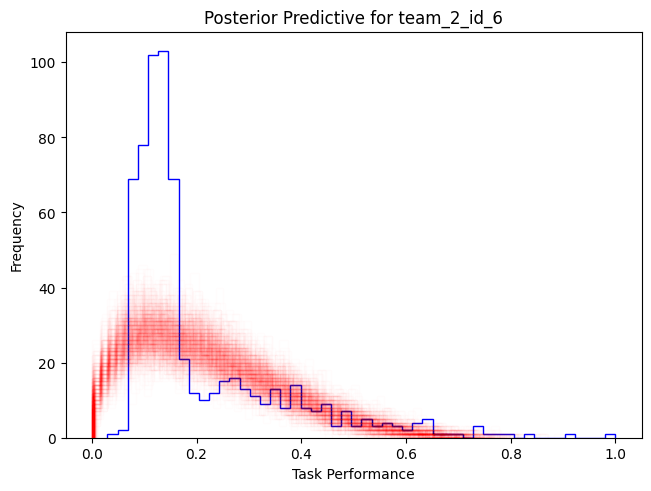

Output()

MSE team_2_id_6: 0.0136
RMSE team_2_id_6: 0.1166
R-squared team_2_id_6: 0.3598

Agent: team_1_id_3 (2/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

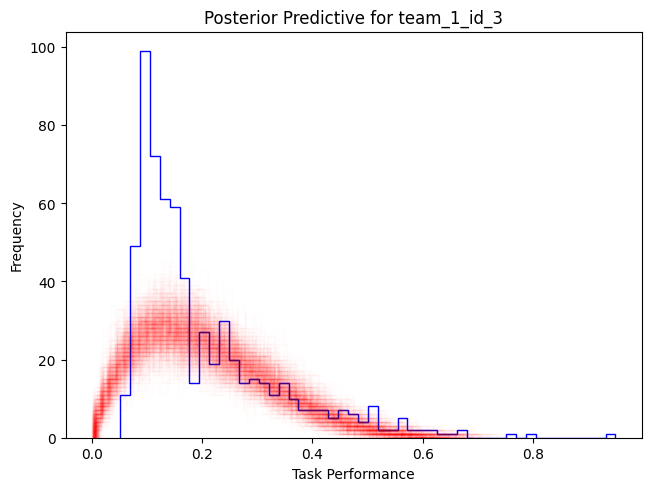

Output()

MSE team_1_id_3: 0.0091
RMSE team_1_id_3: 0.0956
R-squared team_1_id_3: 0.3734

Agent: team_3_id_12 (3/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

Output()

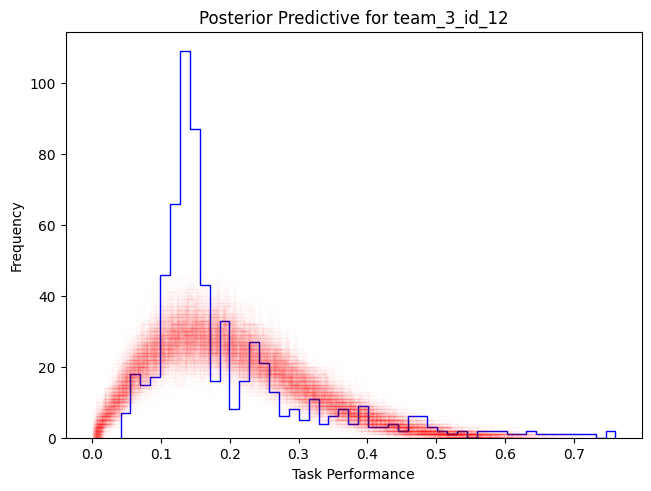

Output()

MSE team_3_id_12: 0.0155
RMSE team_3_id_12: 0.1245
R-squared team_3_id_12: 0.1294

Agent: team_3_id_11 (4/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

Output()

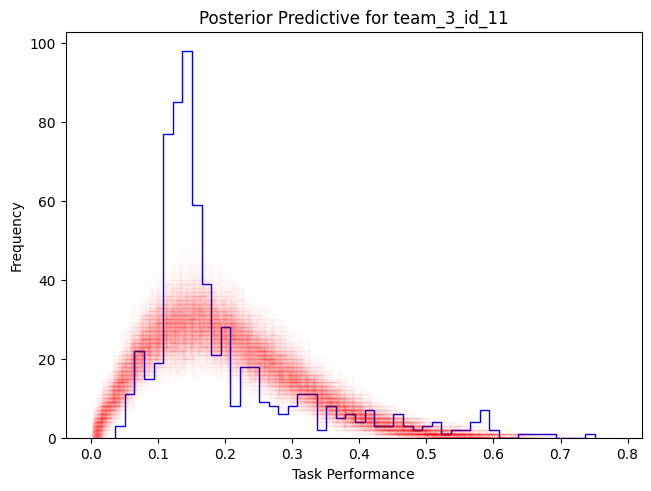

Output()

MSE team_3_id_11: 0.0118
RMSE team_3_id_11: 0.1085
R-squared team_3_id_11: 0.2314

Agent: team_3_id_13 (5/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

Output()

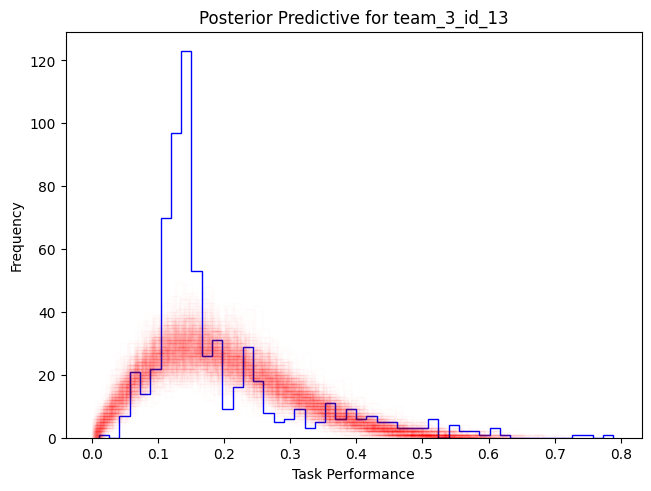

Output()

MSE team_3_id_13: 0.0159
RMSE team_3_id_13: 0.1262
R-squared team_3_id_13: 0.1742

Agent: team_4_id_16 (6/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

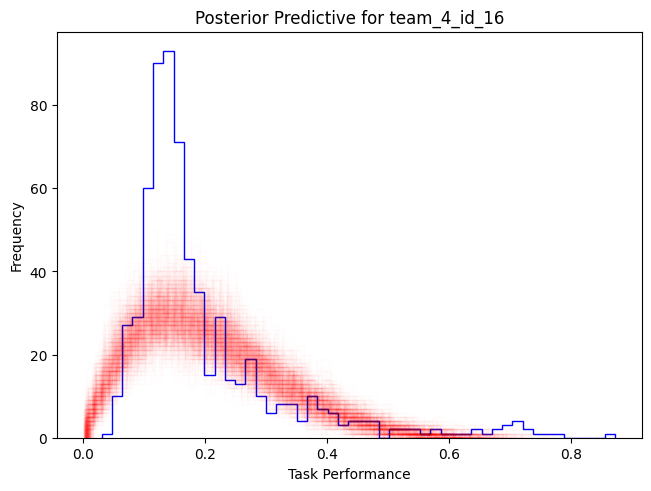

Output()

MSE team_4_id_16: 0.0173
RMSE team_4_id_16: 0.1315
R-squared team_4_id_16: 0.0975

Agent: team_2_id_5 (7/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

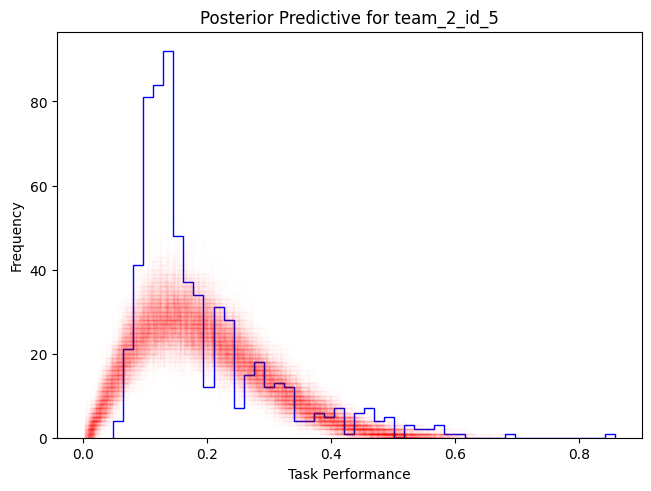

Output()

MSE team_2_id_5: 0.0089
RMSE team_2_id_5: 0.0945
R-squared team_2_id_5: 0.2727

Agent: team_2_id_4 (8/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

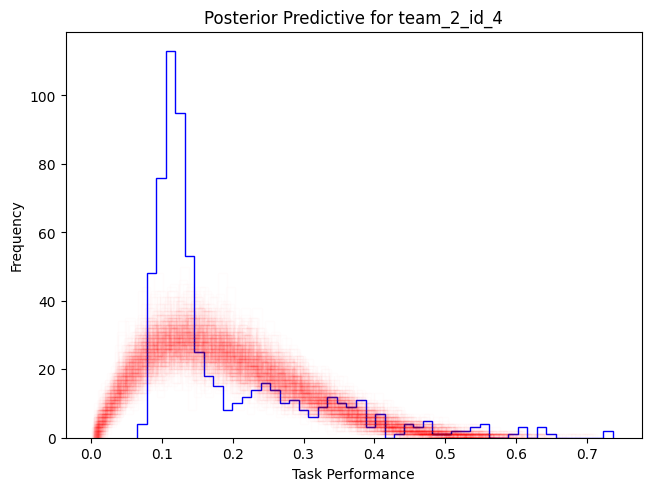

Output()

MSE team_2_id_4: 0.0102
RMSE team_2_id_4: 0.1010
R-squared team_2_id_4: 0.3513

Agent: team_4_id_15 (9/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

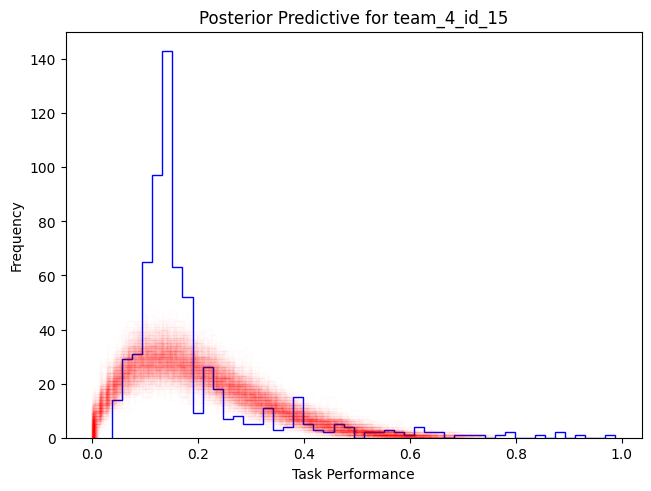

Output()

MSE team_4_id_15: 0.0139
RMSE team_4_id_15: 0.1179
R-squared team_4_id_15: 0.1014

Agent: team_1_id_1 (10/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

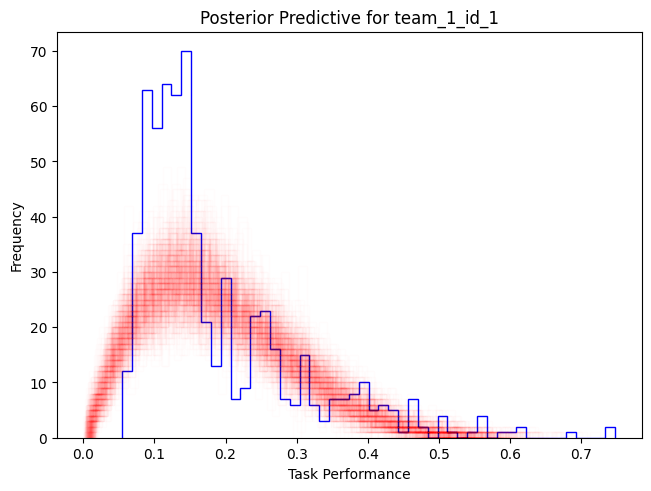

Output()

MSE team_1_id_1: 0.0081
RMSE team_1_id_1: 0.0901
R-squared team_1_id_1: 0.3738

Agent: team_4_id_17 (11/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

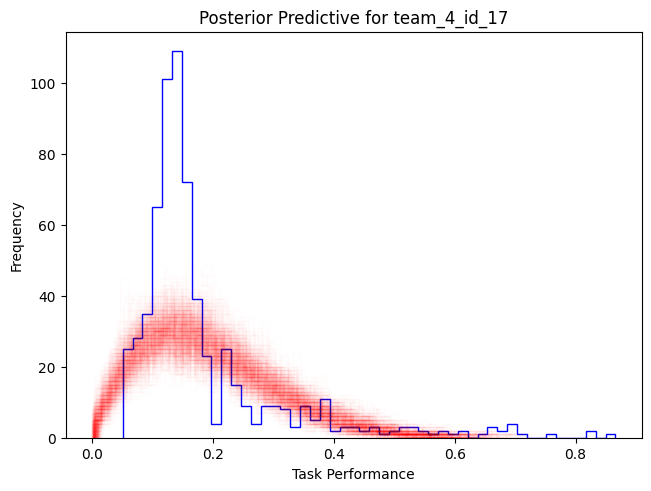

Output()

MSE team_4_id_17: 0.0124
RMSE team_4_id_17: 0.1115
R-squared team_4_id_17: 0.1274

Agent: team_5_id_9 (12/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

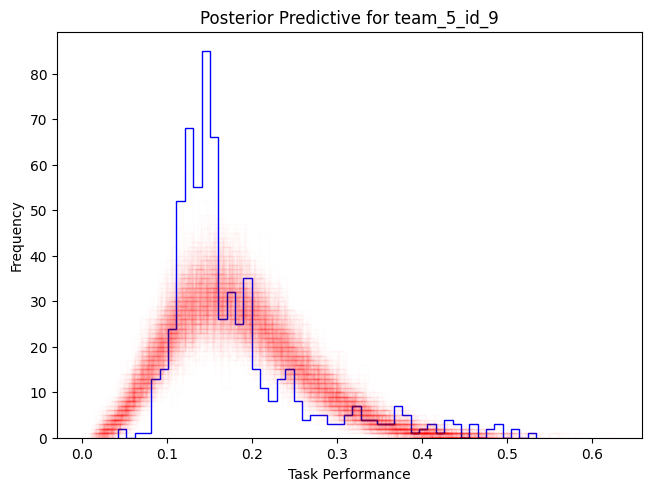

Output()

MSE team_5_id_9: 0.0098
RMSE team_5_id_9: 0.0988
R-squared team_5_id_9: 0.0530

Agent: team_5_id_8 (13/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

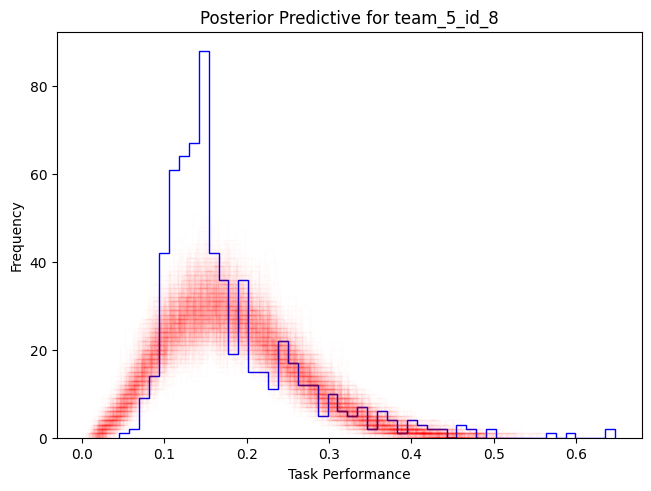

Output()

MSE team_5_id_8: 0.0050
RMSE team_5_id_8: 0.0710
R-squared team_5_id_8: 0.1431

Agent: team_1_id_2 (14/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

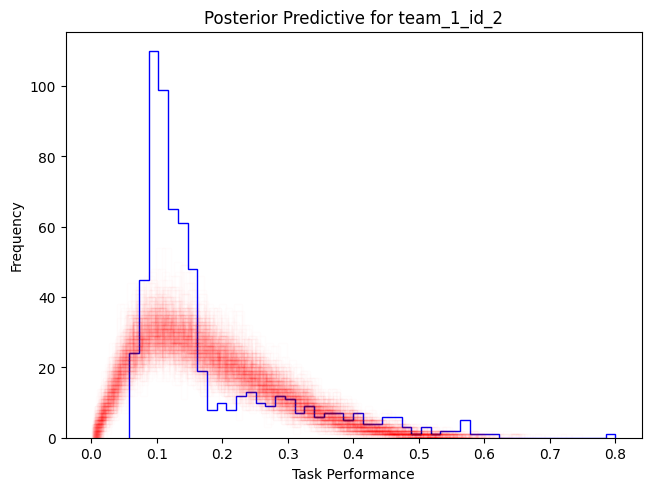

Output()

MSE team_1_id_2: 0.0094
RMSE team_1_id_2: 0.0970
R-squared team_1_id_2: 0.3578

Agent: team_5_id_7 (15/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

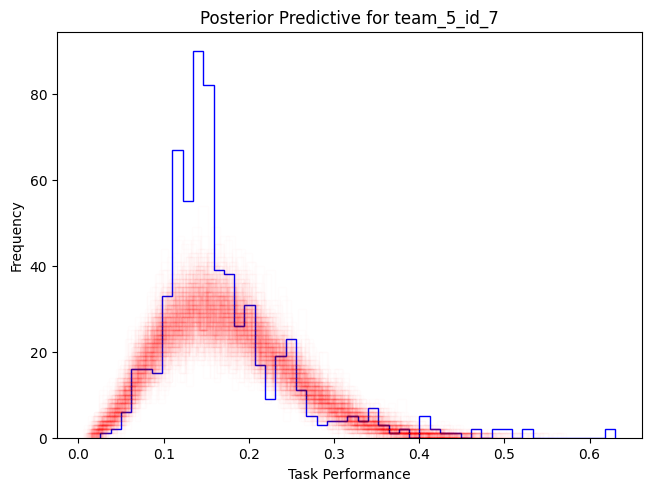

Output()

MSE team_5_id_7: 0.0049
RMSE team_5_id_7: 0.0702
R-squared team_5_id_7: 0.1551

Agent: team_6_id_10 (16/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

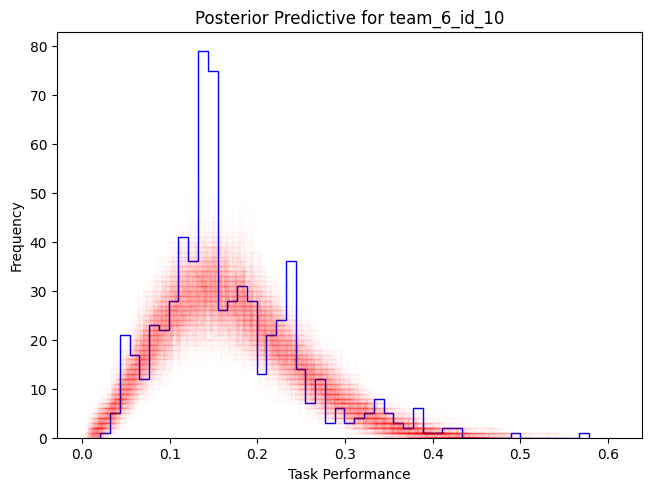

Output()

MSE team_6_id_10: 0.0050
RMSE team_6_id_10: 0.0706
R-squared team_6_id_10: 0.0903

Agent: team_7_id_14 (17/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

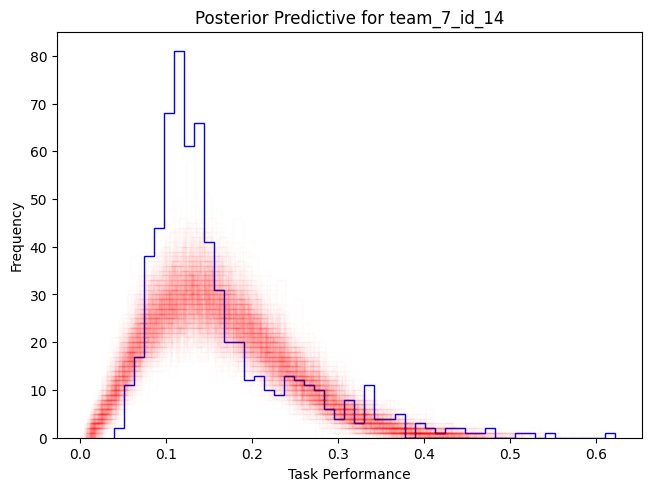

Output()

MSE team_7_id_14: 0.0061
RMSE team_7_id_14: 0.0784
R-squared team_7_id_14: 0.2418

Agent: team_8_id_18 (18/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

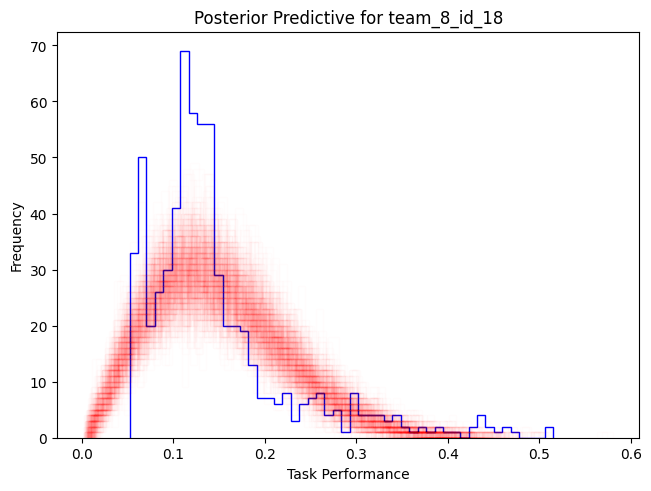

Output()

MSE team_8_id_18: 0.0056
RMSE team_8_id_18: 0.0750
R-squared team_8_id_18: 0.2473

Agent: team_9_id_22 (19/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

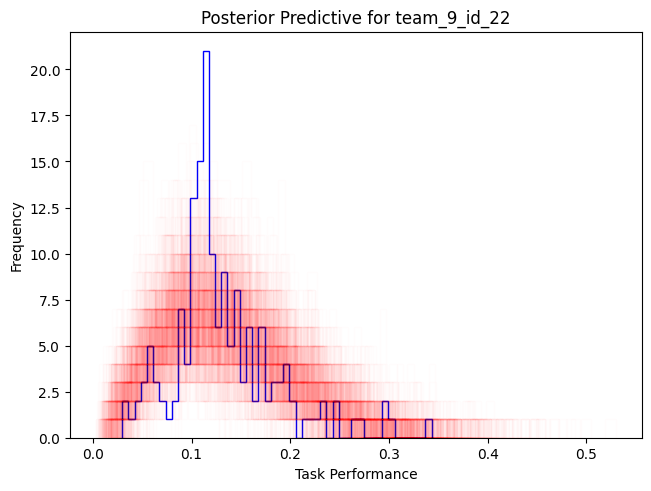

Output()

MSE team_9_id_22: 0.0018
RMSE team_9_id_22: 0.0429
R-squared team_9_id_22: 0.3141

Agent: team_9_id_21 (20/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

Output()

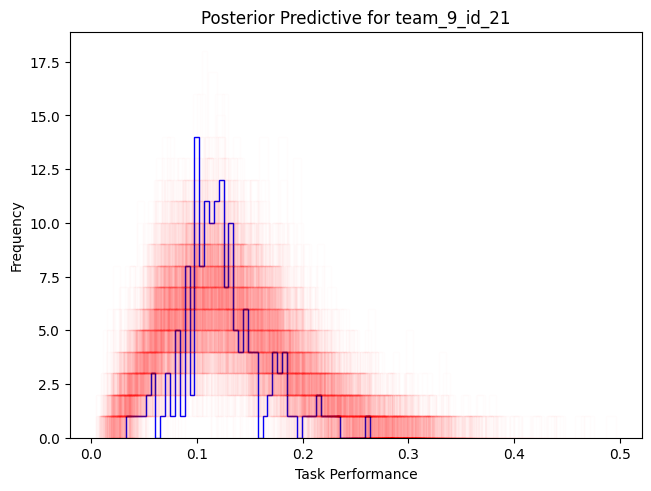

Output()

MSE team_9_id_21: 0.0020
RMSE team_9_id_21: 0.0446
R-squared team_9_id_21: 0.1558

Agent: team_10_id_23 (21/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

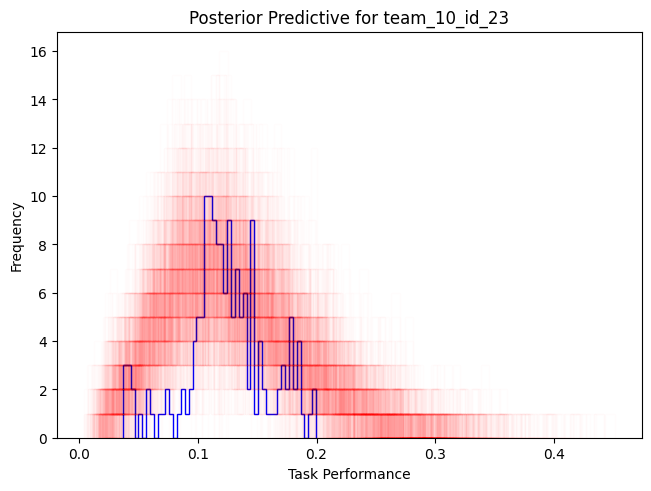

Output()

MSE team_10_id_23: 0.0007
RMSE team_10_id_23: 0.0273
R-squared team_10_id_23: 0.3397

Agent: team_9_id_20 (22/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

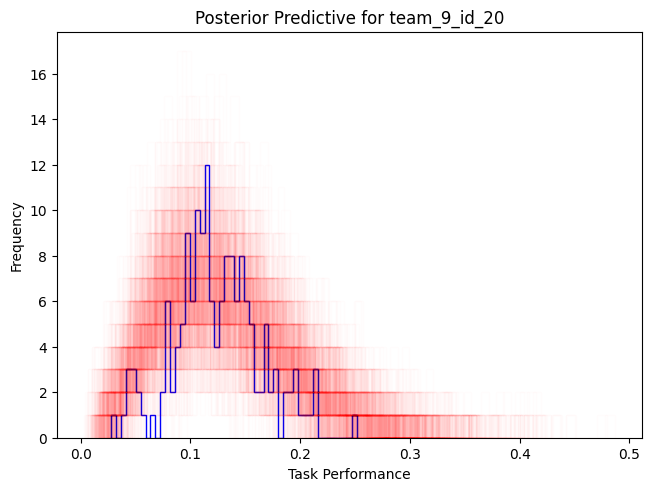

Output()

MSE team_9_id_20: 0.0011
RMSE team_9_id_20: 0.0330
R-squared team_9_id_20: 0.3160

Agent: team_11_id_24 (23/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

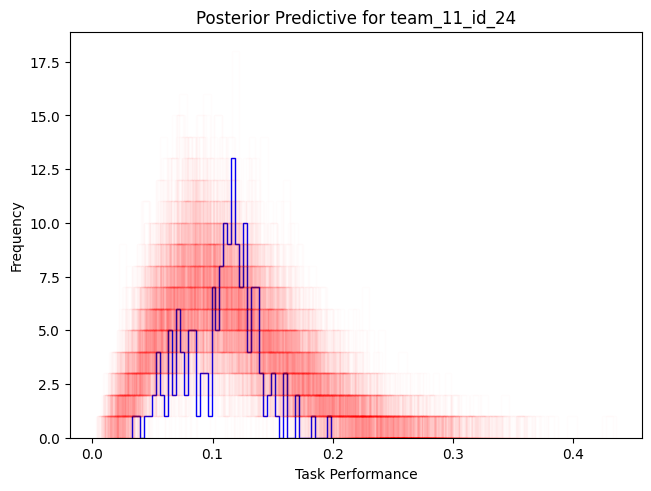

Output()

MSE team_11_id_24: 0.0008
RMSE team_11_id_24: 0.0279
R-squared team_11_id_24: 0.1014

Agent: team_11_id_25 (24/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

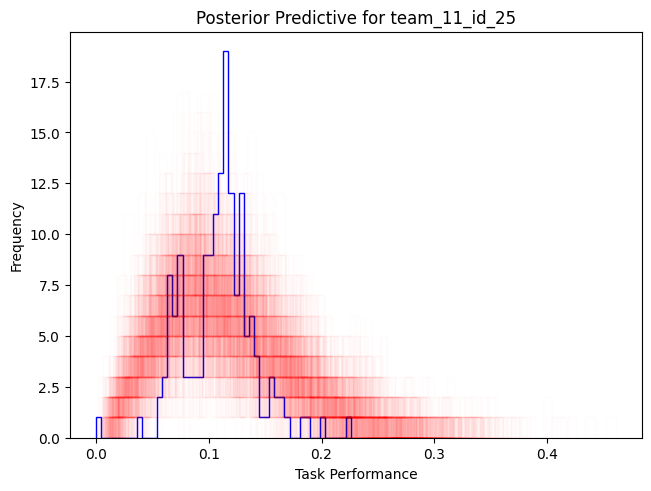

Output()

MSE team_11_id_25: 0.0011
RMSE team_11_id_25: 0.0328
R-squared team_11_id_25: -0.3452

Agent: team_12_id_19 (25/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

Output()

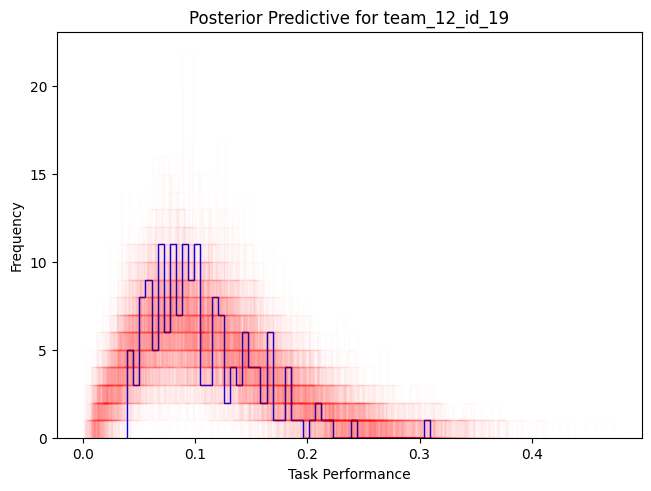

Output()

MSE team_12_id_19: 0.0012
RMSE team_12_id_19: 0.0349
R-squared team_12_id_19: 0.2967

Agent: team_11_id_26 (26/26), score: MinMax Normalized Score AA, distribution: Beta



/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

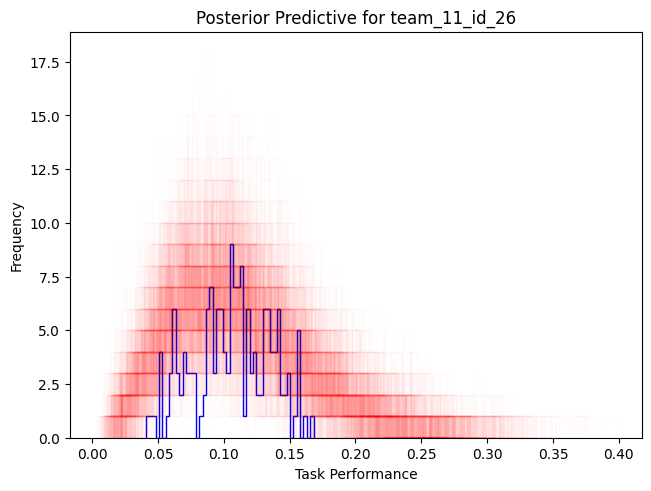

Output()

MSE team_11_id_26: 0.0008
RMSE team_11_id_26: 0.0291
R-squared team_11_id_26: -0.1728

Metrics Summary:


Agent                   Parameter    Mean  HDI 3%  HDI 97%  \
0      team_2_id_6   abilityProsocialNewcomers   0.378   0.249    0.506   
1      team_2_id_6              abilityVisitor   0.724   0.644    0.801   
2      team_2_id_6         abilityTimePressure   0.390   0.296    0.479   
3      team_2_id_6  abilityConventionFollowing   0.351   0.310    0.393   
4      team_2_id_6             abilityTeaching   0.740   0.578    0.915   
5      team_2_id_6          abilityForgiveness   0.685   0.533    0.846   
6      team_2_id_6          abilityReciprocity   0.538   0.488    0.589   
7      team_2_id_6                 base_chance   0.853   0.846    0.859   
8      team_2_id_6                  sampleSize  10.826   9.761   11.974   
9      team_1_id_3   abilityProsocialNewcomers   0.420   0.293    0.539   
10     team_1_id_3              abilityVisitor   0.974   0.934    1.000   
11     team_1_id_3         abilityTimePressure   0.393   0.303    0.476   
12     team_1_id_3  abilityConventionFollowing   0.570   0.521    0.623   
13     team_1_id_3             abilityTeaching   0.767   0.613    0.922   
14     team_1_id_3          abilityForgiveness   0.802   0.649    0.959   
15     team_1_id_3          abilityReciprocity   0.417   0.381    0.454   
16     team_1_id_3                 base_chance   0.837   0.831    0.842   
17     team_1_id_3                  sampleSize  15.239  13.699   16.755   
18    team_3_id_12   abilityProsocialNewcomers   0.498   0.367    0.623   
19    team_3_id_12              abilityVisitor   0.567   0.506    0.630   
20    team_3_id_12         abilityTimePressure   0.488   0.386    0.600   
21    team_3_id_12  abilityConventionFollowing   0.601   0.546    0.657   
22    team_3_id_12             abilityTeaching   0.720   0.585    0.862   
23    team_3_id_12          abilityForgiveness   0.766   0.629    0.920   
24    team_3_id_12          abilityReciprocity   0.611   0.557    0.668   
25    team_3_id_12                 base_chance   0.828   0.821    0.834   
26    team_3_id_12                  sampleSize  15.664  14.070   17.275   
27    team_3_id_11   abilityProsocialNewcomers   0.509   0.343    0.669   
28    team_3_id_11              abilityVisitor   0.545   0.483    0.607   
29    team_3_id_11         abilityTimePressure   0.516   0.402    0.630   
30    team_3_id_11  abilityConventionFollowing   0.613   0.555    0.669   
31    team_3_id_11             abilityTeaching   0.729   0.586    0.869   
32    team_3_id_11          abilityForgiveness   0.707   0.572    0.844   
33    team_3_id_11          abilityReciprocity   0.664   0.603    0.721   
34    team_3_id_11                 base_chance   0.824   0.818    0.831   
35    team_3_id_11                  sampleSize  15.310  13.769   16.841   
36    team_3_id_13   abilityProsocialNewcomers   0.490   0.348    0.626   
37    team_3_id_13              abilityVisitor   0.502   0.445    0.559   
38    team_3_id_13         abilityTimePressure   0.523   0.425    0.621   
39    team_3_id_13  abilityConventionFollowing   0.632   0.577    0.691   
40    team_3_id_13             abilityTeaching   0.697   0.569    0.844   
41    team_3_id_13          abilityForgiveness   0.704   0.566    0.842   
42    team_3_id_13          abilityReciprocity   0.681   0.624    0.742   
43    team_3_id_13                 base_chance   0.822   0.816    0.829   
44    team_3_id_13                  sampleSize  16.235  14.629   17.922   
45    team_4_id_16   abilityProsocialNewcomers   0.519   0.370    0.685   
46    team_4_id_16              abilityVisitor   0.619   0.543    0.689   
47    team_4_id_16         abilityTimePressure   0.551   0.430    0.676   
48    team_4_id_16  abilityConventionFollowing   0.653   0.586    0.722   
49    team_4_id_16             abilityTeaching   0.708   0.561    0.855   
50    team_4_id_16          abilityForgiveness   0.718   0.572    0.875   
51    team_4_id_16          abilityReciprocity   0.712   0.645    0.782   
52    team_4_id_16                 bas

In [ ]:
metrics_dict_normalized_score, data_mes_normalized_score, metrics_df_normalized_score = process_agents(
    sorted_agents_norm_score, competition_train_df, competition_test_df,
    common_features_aggregate, score = 'MinMax Normalized Score AA', dist = 'Beta', other_parameters = ['base_chance','sampleSize']
)

predictive_method          Agent  \
0                                            meanScore    team_2_id_6   
1                                            meanScore    team_1_id_3   
2                                            meanScore   team_3_id_12   
3                                            meanScore   team_3_id_11   
4                                            meanScore   team_3_id_13   
..                                                 ...            ...   
125  Measurement layout (Beta & MinMax Normalized S...   team_9_id_20   
126  Measurement layout (Beta & MinMax Normalized S...  team_11_id_24   
127  Measurement layout (Beta & MinMax Normalized S...  team_11_id_25   
128  Measurement layout (Beta & MinMax Normalized S...  team_12_id_19   
129  Measurement layout (Beta & MinMax Normalized S...  team_11_id_26   

          MSE      RMSE        R2  
0    0.021244  0.145755 -0.000095  
1    0.014653  0.121051 -0.004298  
2    0.017898  0.133783 -0.005478  
3    0.015392  0.124066 -0.005869  
4    0.019729  0.140460 -0.022983  
..        ...       ...       ...  
125  0.001091  0.033029  0.315989  
126  0.000777  0.027870  0.101426  
127  0.001077  0.032819 -0.345248  
128  0.001219  0.034910  0.296685  
129  0.000844  0.029054 -0.172819  

[130 rows x 5 columns]

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

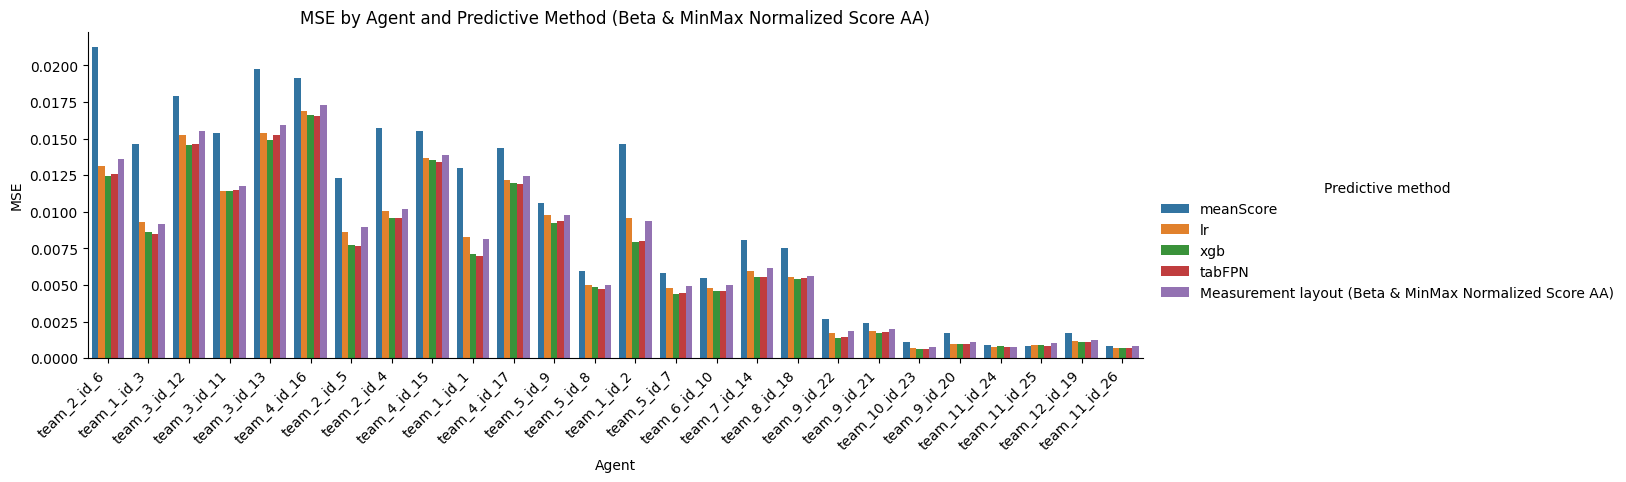

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

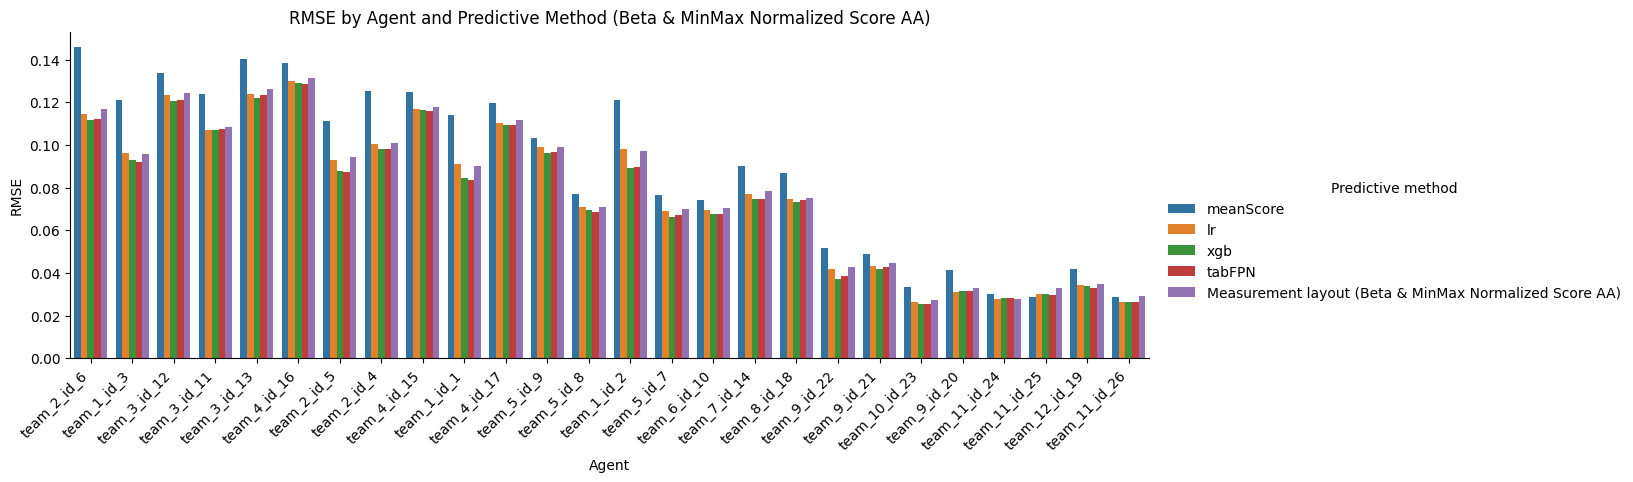

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

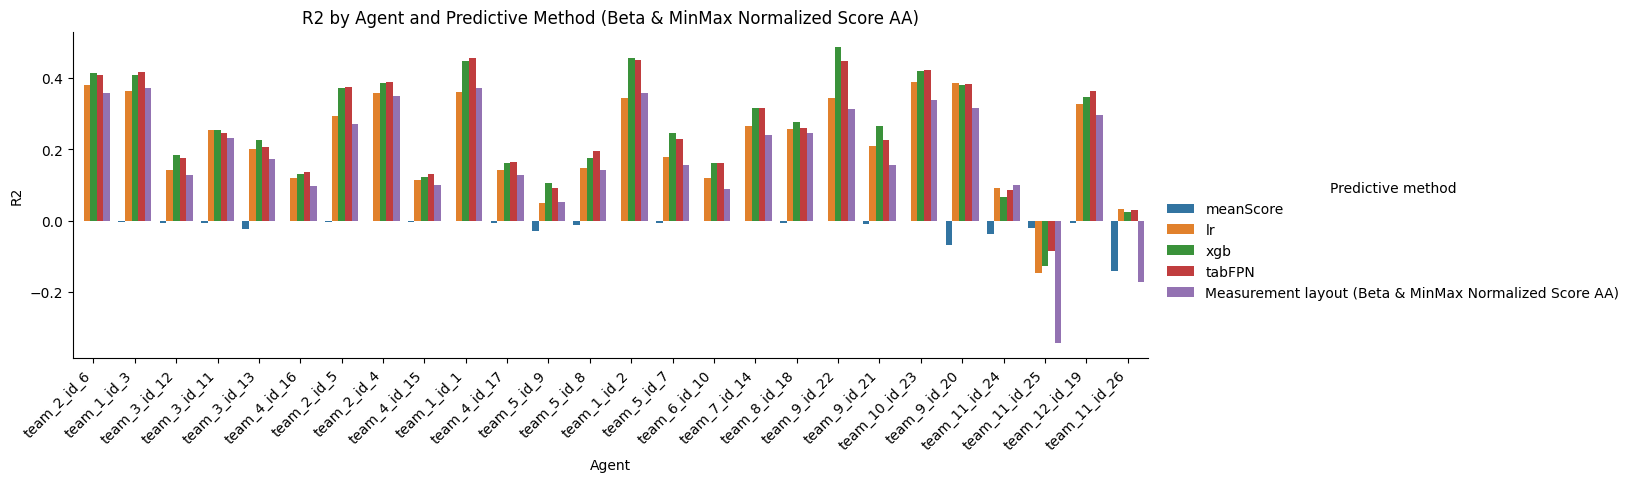

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


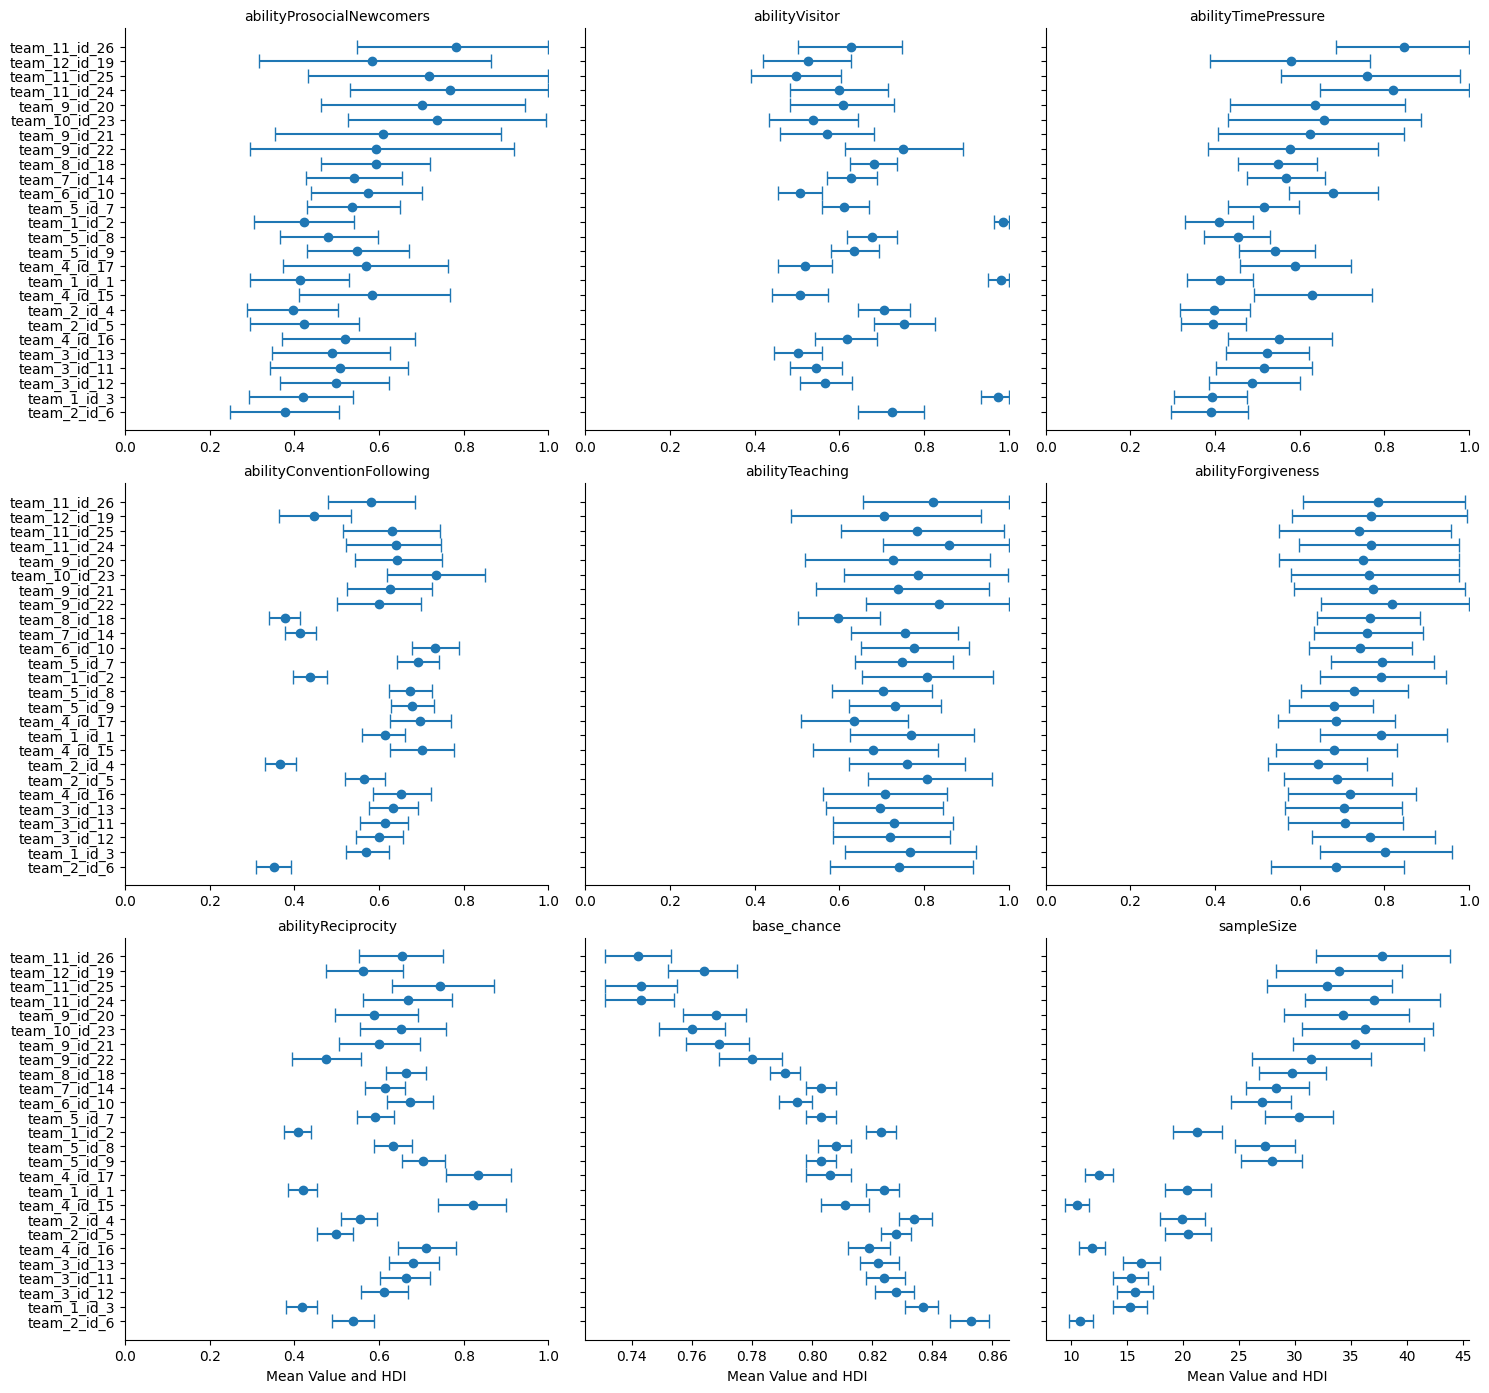

Agent   Mean
1   team_11_id_24  5.123
3   team_11_id_26  5.096
2   team_11_id_25  4.871
0   team_10_id_23  4.868
20   team_6_id_10  4.682
23   team_9_id_20  4.652
25   team_9_id_22  4.652
14   team_4_id_15  4.604
24   team_9_id_21  4.546
16   team_4_id_17  4.530
19    team_5_id_9  4.518
17    team_5_id_7  4.489
15   team_4_id_16  4.480
5     team_1_id_1  4.399
18    team_5_id_8  4.349
7     team_1_id_3  4.343
11   team_3_id_11  4.283
21   team_7_id_14  4.279
6     team_1_id_2  4.264
12   team_3_id_12  4.251
13   team_3_id_13  4.229
22   team_8_id_18  4.227
4   team_12_id_19  4.172
9     team_2_id_5  4.126
8     team_2_id_4  3.825
10    team_2_id_6  3.806

In [ ]:
summary_df_normalized_score = plot_metrics_and_summary(metrics_dict_normalized_score, data_mes_normalized_score,
                                      assessors_minmax_normalized_score_aa, common_features_aggregate, dist = 'Beta', score = 'MinMax Normalized Score AA')

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



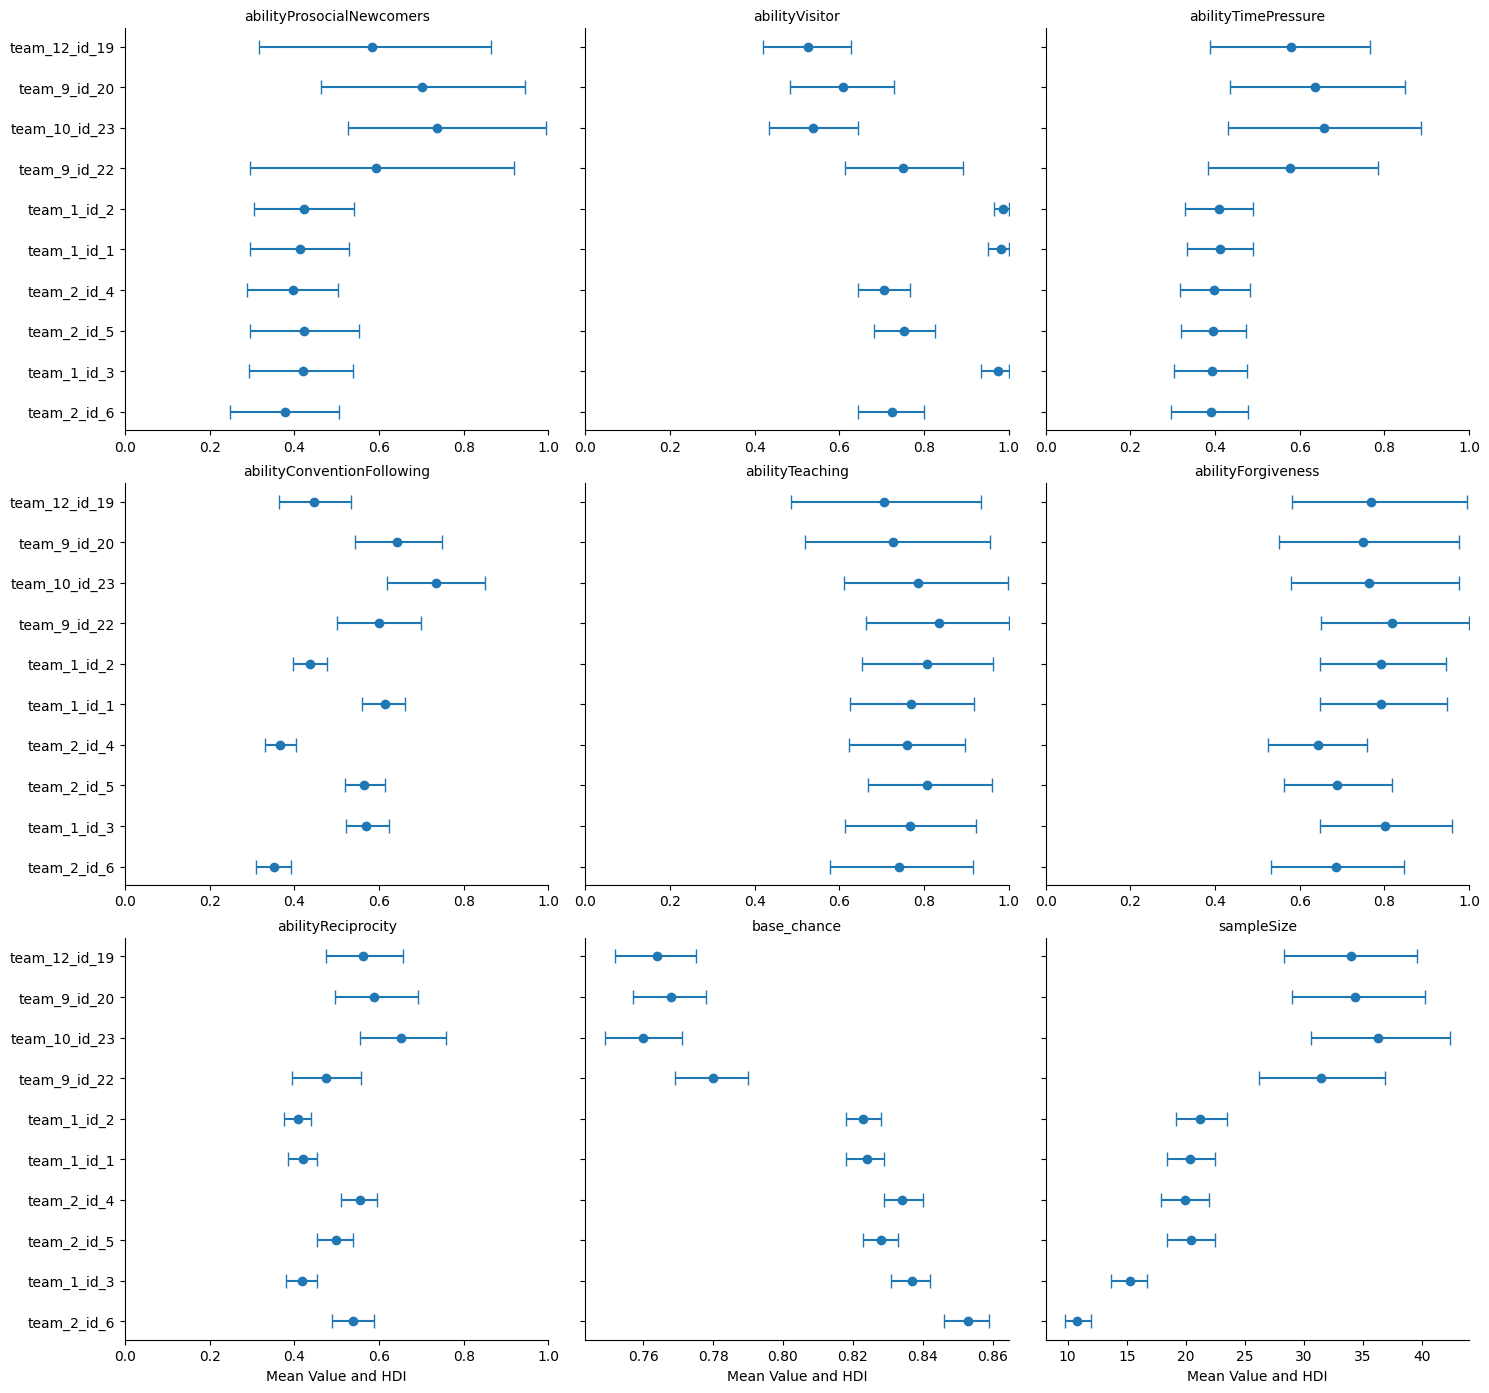

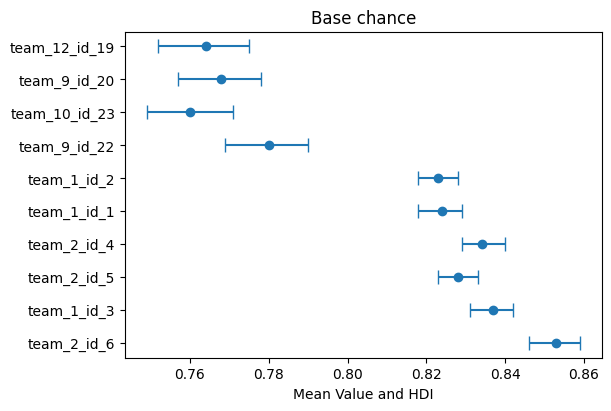

In [ ]:
plot_abilities(metrics_dict_normalized_score, data_mes_normalized_score,
               assessors_minmax_normalized_score_aa, common_features_aggregate, R2 = 0.25, save = True, note = 'normalized_score')